In [1]:
# Basic libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import os
import cv2
from PIL import Image

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Image processing and filters
from scipy import ndimage
from scipy.ndimage import gaussian_filter, sobel, prewitt
from skimage import filters, feature, exposure, transform
from skimage.feature import local_binary_pattern
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")

All libraries imported successfully!
TensorFlow version: 2.20.0
OpenCV version: 4.12.0


In [2]:
# Define dataset path
dataset_path = "C:/Users/sanap/Downloads/Dataset 2"

# Check if dataset exists
if not os.path.exists(dataset_path):
    print(f"Dataset path '{dataset_path}' not found!")
    print("Please make sure the dataset folder exists in your current directory.")
else:
    print("Dataset folder found!")
    
    # Check subfolders
    positive_path = os.path.join(dataset_path, "positive")
    negative_path = os.path.join(dataset_path, "negative")
    
    if os.path.exists(positive_path) and os.path.exists(negative_path):
        print("✓ Both 'positive' and 'negative' folders found!")
        
        # Count images in each folder
        positive_images = os.listdir(positive_path)
        negative_images = os.listdir(negative_path)
        
        print(f"Number of positive images (with cracks): {len(positive_images)}")
        print(f"Number of negative images (without cracks): {len(negative_images)}")
        print(f"Total images: {len(positive_images) + len(negative_images)}")
        
        # Check image formats
        positive_formats = set([os.path.splitext(img)[1].lower() for img in positive_images])
        negative_formats = set([os.path.splitext(img)[1].lower() for img in negative_images])
        
        print(f"Image formats in positive folder: {positive_formats}")
        print(f"Image formats in negative folder: {negative_formats}")
        
    else:
        print("✗ 'positive' and/or 'negative' folders not found!")
        print("Please check your dataset structure.")

Dataset folder found!
✓ Both 'positive' and 'negative' folders found!
Number of positive images (with cracks): 20000
Number of negative images (without cracks): 20000
Total images: 40000
Image formats in positive folder: {'.jpg'}
Image formats in negative folder: {'.jpg'}


In [3]:
def load_images_from_folder(folder_path, label, max_images=None):
    """
    Load images from a folder with error handling
    
    Parameters:
    - folder_path: path to the folder containing images
    - label: label for these images (0 for negative, 1 for positive)
    - max_images: maximum number of images to load (None for all)
    
    Returns:
    - images: list of image arrays
    - labels: list of labels
    - failed_images: list of images that failed to load
    """
    images = []
    labels = []
    failed_images = []
    
    # Get list of image files
    image_files = [f for f in os.listdir(folder_path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    # Limit number of images if specified
    if max_images:
        image_files = image_files[:max_images]
    
    print(f"Loading {len(image_files)} images from {folder_path}...")
    
    for image_file in tqdm(image_files):
        try:
            img_path = os.path.join(folder_path, image_file)
            
            # Load image using OpenCV
            img = cv2.imread(img_path)
            
            if img is not None:
                # Convert BGR to RGB
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img_rgb)
                labels.append(label)
            else:
                failed_images.append(image_file)
                
        except Exception as e:
            failed_images.append(image_file)
            print(f"Error loading {image_file}: {str(e)}")
    
    if failed_images:
        print(f"Failed to load {len(failed_images)} images")
    
    return images, labels, failed_images

# Load a sample of images to test (let's start with 1000 from each class for testing)
print("Loading sample images for testing...")
positive_images, positive_labels, positive_failed = load_images_from_folder(positive_path, 1, max_images=1000)
negative_images, negative_labels, negative_failed = load_images_from_folder(negative_path, 0, max_images=1000)

print(f"Successfully loaded {len(positive_images)} positive images")
print(f"Successfully loaded {len(negative_images)} negative images")

Loading sample images for testing...
Loading 1000 images from C:/Users/sanap/Downloads/Dataset 2\positive...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.25it/s]


Loading 1000 images from C:/Users/sanap/Downloads/Dataset 2\negative...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.43it/s]

Successfully loaded 1000 positive images
Successfully loaded 1000 negative images


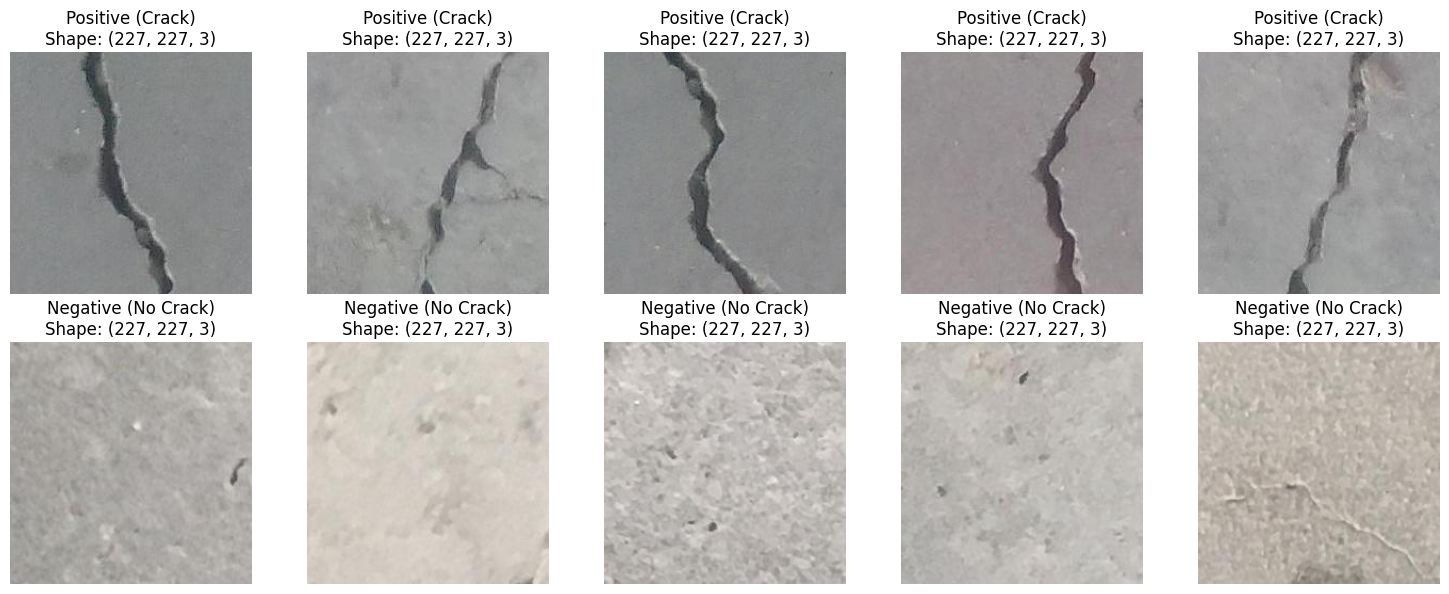

In [4]:
def display_sample_images(positive_images, negative_images, num_samples=5):
    """
    Display sample images from both classes
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    # Display positive samples (with cracks)
    for i in range(num_samples):
        if i < len(positive_images):
            axes[0, i].imshow(positive_images[i])
            axes[0, i].set_title(f"Positive (Crack)\nShape: {positive_images[i].shape}")
            axes[0, i].axis('off')
    
    # Display negative samples (without cracks)
    for i in range(num_samples):
        if i < len(negative_images):
            axes[1, i].imshow(negative_images[i])
            axes[1, i].set_title(f"Negative (No Crack)\nShape: {negative_images[i].shape}")
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
if positive_images and negative_images:
    display_sample_images(positive_images, negative_images, num_samples=5)
else:
    print("No images loaded to display!")

In [5]:
def analyze_image_properties(positive_images, negative_images):
    """
    Analyze basic properties of the loaded images
    """
    print("=== IMAGE PROPERTIES ANALYSIS ===")
    
    if positive_images:
        positive_shapes = [img.shape for img in positive_images]
        positive_heights = [shape[0] for shape in positive_shapes]
        positive_widths = [shape[1] for shape in positive_shapes]
        positive_channels = [shape[2] if len(shape) > 2 else 1 for shape in positive_shapes]
        
        print("\nPositive Images (Cracks):")
        print(f"  - Average height: {np.mean(positive_heights):.2f}")
        print(f"  - Average width: {np.mean(positive_widths):.2f}")
        print(f"  - Number of channels: {set(positive_channels)}")
        print(f"  - Shape range: Height({min(positive_heights)}-{max(positive_heights)}), "
              f"Width({min(positive_widths)}-{max(positive_widths)})")
    
    if negative_images:
        negative_shapes = [img.shape for img in negative_images]
        negative_heights = [shape[0] for shape in negative_shapes]
        negative_widths = [shape[1] for shape in negative_shapes]
        negative_channels = [shape[2] if len(shape) > 2 else 1 for shape in negative_shapes]
        
        print("\nNegative Images (No Cracks):")
        print(f"  - Average height: {np.mean(negative_heights):.2f}")
        print(f"  - Average width: {np.mean(negative_widths):.2f}")
        print(f"  - Number of channels: {set(negative_channels)}")
        print(f"  - Shape range: Height({min(negative_heights)}-{max(negative_heights)}), "
              f"Width({min(negative_widths)}-{max(negative_widths)})")

# Analyze image properties
if positive_images and negative_images:
    analyze_image_properties(positive_images, negative_images)

=== IMAGE PROPERTIES ANALYSIS ===

Positive Images (Cracks):
  - Average height: 227.00
  - Average width: 227.00
  - Number of channels: {3}
  - Shape range: Height(227-227), Width(227-227)

Negative Images (No Cracks):
  - Average height: 227.00
  - Average width: 227.00
  - Number of channels: {3}
  - Shape range: Height(227-227), Width(227-227)


In [6]:
print("=== LOADING FULL DATASET (40,000 IMAGES) ===")

def load_full_dataset_optimized(positive_path, negative_path, img_size=(128, 128), test_size=5000, random_state=42):
    """
    Optimized function to load full dataset with resizing to save memory
    """
    # Get all image file paths
    positive_files = [os.path.join(positive_path, f) for f in os.listdir(positive_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    negative_files = [os.path.join(negative_path, f) for f in os.listdir(negative_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    print(f"Found {len(positive_files)} positive images")
    print(f"Found {len(negative_files)} negative images")
    
    # Shuffle the files
    random.shuffle(positive_files)
    random.shuffle(negative_files)
    
    # Calculate split sizes (35,000 train + 5,000 test)
    total_positive = len(positive_files)
    total_negative = len(negative_files)
    
    # For balanced dataset, take proportional from each class
    positive_test_count = int(test_size * (total_positive / (total_positive + total_negative)))
    negative_test_count = test_size - positive_test_count
    
    print(f"\nSplitting strategy:")
    print(f"Positive - Train: {total_positive - positive_test_count}, Test: {positive_test_count}")
    print(f"Negative - Train: {total_negative - negative_test_count}, Test: {negative_test_count}")
    
    # Initialize lists
    X_train, X_test = [], []
    y_train, y_test = [], []
    
    # Load positive images
    print("\nLoading positive images...")
    for i, file_path in enumerate(tqdm(positive_files)):
        try:
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)  # Resize to save memory
                
                if i < positive_test_count:
                    X_test.append(img)
                    y_test.append(1)  # Positive label
                else:
                    X_train.append(img)
                    y_train.append(1)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    # Load negative images  
    print("\nLoading negative images...")
    for i, file_path in enumerate(tqdm(negative_files)):
        try:
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)  # Resize to save memory
                
                if i < negative_test_count:
                    X_test.append(img)
                    y_test.append(0)  # Negative label
                else:
                    X_train.append(img)
                    y_train.append(0)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # Final shuffle
    train_indices = np.random.permutation(len(X_train))
    test_indices = np.random.permutation(len(X_test))
    
    X_train, y_train = X_train[train_indices], y_train[train_indices]
    X_test, y_test = X_test[test_indices], y_test[test_indices]
    
    print(f"\n✓ Dataset loaded successfully!")
    print(f"✓ Training set: {X_train.shape[0]} images")
    print(f"✓ Testing set: {X_test.shape[0]} images")
    print(f"✓ Image shape: {X_train[0].shape}")
    print(f"✓ Training labels - 0 (No Crack): {np.sum(y_train == 0)}, 1 (Crack): {np.sum(y_train == 1)}")
    print(f"✓ Testing labels - 0 (No Crack): {np.sum(y_test == 0)}, 1 (Crack): {np.sum(y_test == 1)}")
    
    return X_train, X_test, y_train, y_test

# Load the full dataset with resizing to manage memory
X_train, X_test, y_train, y_test = load_full_dataset_optimized(positive_path, negative_path, img_size=(128, 128))

print("\n" + "="*50)
print("DATASET READY FOR TRAINING!")
print("="*50)

=== LOADING FULL DATASET (40,000 IMAGES) ===
Found 20000 positive images
Found 20000 negative images

Splitting strategy:
Positive - Train: 17500, Test: 2500
Negative - Train: 17500, Test: 2500

Loading positive images...


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:03<00:00, 82.11it/s]



Loading negative images...


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:11<00:00, 79.46it/s]



✓ Dataset loaded successfully!
✓ Training set: 35000 images
✓ Testing set: 5000 images
✓ Image shape: (128, 128, 3)
✓ Training labels - 0 (No Crack): 17500, 1 (Crack): 17500
✓ Testing labels - 0 (No Crack): 2500, 1 (Crack): 2500

DATASET READY FOR TRAINING!


In [7]:
# Apply Canny Edge Detector - Best for Crack Detection
print("=== APPLYING CANNY EDGE DETECTOR FOR CRACK DETECTION ===")

def apply_canny_edge_detector(images, low_threshold=50, high_threshold=150):
    """
    Apply Canny edge detection to a batch of images
    Canny is excellent for detecting cracks as it highlights linear features
    """
    canny_images = []
    
    for img in tqdm(images):
        # Convert to grayscale first
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Apply Canny edge detection
        edges = cv2.Canny(blurred, low_threshold, high_threshold)
        
        # Convert back to 3-channel for visualization
        edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        canny_images.append(edges_rgb)
    
    return np.array(canny_images)

# Apply Canny filter to a sample of training images (first 1000 for demonstration)
print("Applying Canny edge detector to training images...")
X_train_canny = apply_canny_edge_detector(X_train[:1000])
X_test_canny = apply_canny_edge_detector(X_test[:200])  # Smaller test sample for demo

print(f"Original images shape: {X_train[:1000].shape}")
print(f"Canny processed images shape: {X_train_canny.shape}")

=== APPLYING CANNY EDGE DETECTOR FOR CRACK DETECTION ===
Applying Canny edge detector to training images...


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4163.51it/s]

Original images shape: (1000, 128, 128, 3)
Canny processed images shape: (1000, 128, 128, 3)


Visualizing Canny Edge Detection Results...


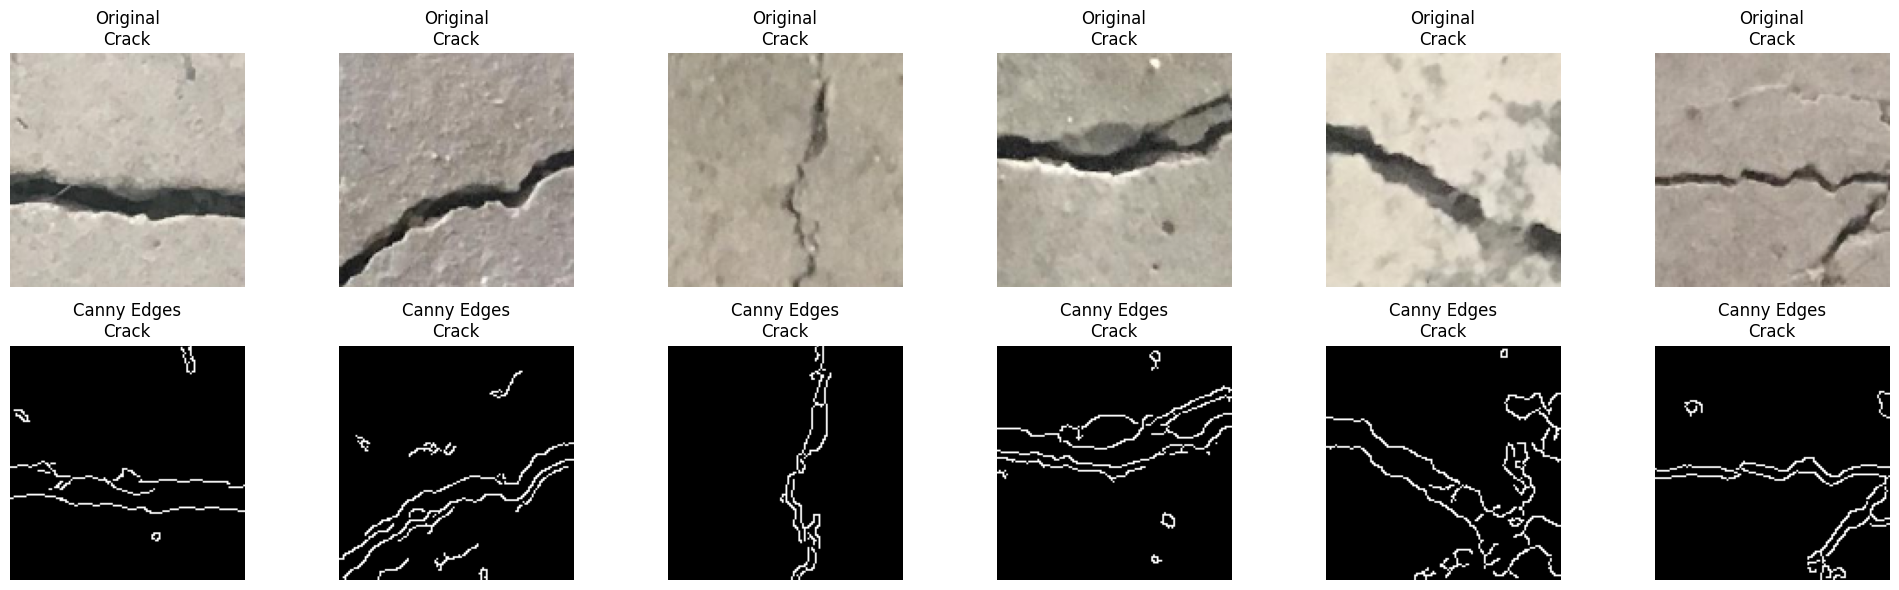

In [8]:
# Visualize original vs Canny filtered images
def compare_original_vs_canny(original_images, canny_images, labels, num_samples=8):
    """
    Compare original images with their Canny edge detection results
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
    
    # Select random samples with both classes
    positive_indices = np.where(labels[:num_samples*2] == 1)[0][:num_samples]
    negative_indices = np.where(labels[:num_samples*2] == 0)[0][:num_samples]
    
    selected_indices = list(positive_indices) + list(negative_indices)
    selected_indices = selected_indices[:num_samples]
    
    # Plot original images
    for i, idx in enumerate(selected_indices):
        if i < num_samples:
            axes[0, i].imshow(original_images[idx])
            class_name = "Crack" if labels[idx] == 1 else "No Crack"
            axes[0, i].set_title(f"Original\n{class_name}")
            axes[0, i].axis('off')
    
    # Plot Canny filtered images
    for i, idx in enumerate(selected_indices):
        if i < num_samples:
            axes[1, i].imshow(canny_images[idx])
            class_name = "Crack" if labels[idx] == 1 else "No Crack"
            axes[1, i].set_title(f"Canny Edges\n{class_name}")
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Compare original vs Canny filtered images
print("Visualizing Canny Edge Detection Results...")
compare_original_vs_canny(X_train[:1000], X_train_canny, y_train[:1000], num_samples=6)

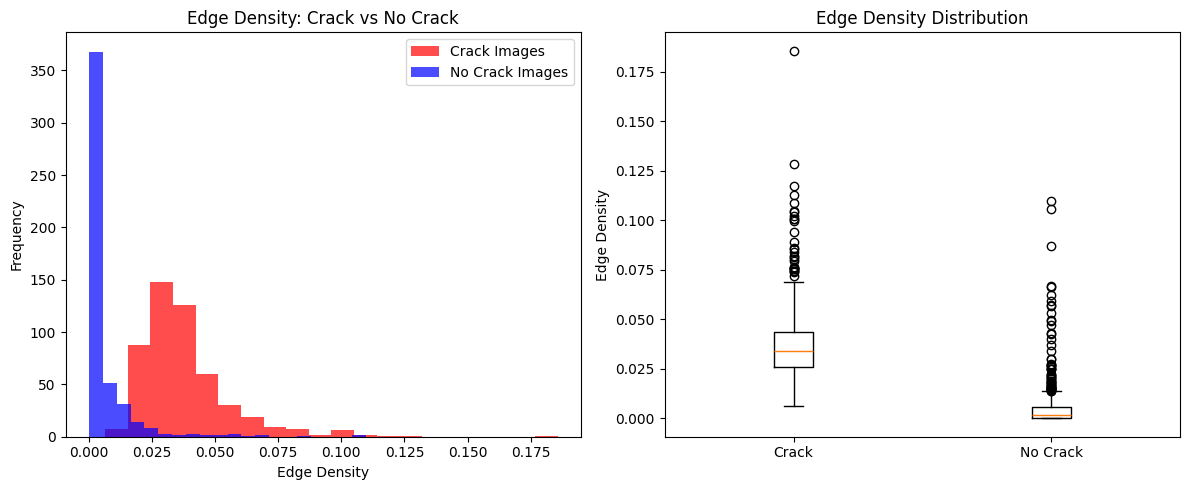

=== CANNY EDGE DENSITY ANALYSIS ===
Average edge density in CRACK images: 0.0379
Average edge density in NO CRACK images: 0.0060
Crack images have 6.37x more edges


In [9]:
# Analyze crack features in Canny images
def analyze_canny_features(canny_images, labels):
    """
    Analyze how Canny edge detection captures crack features
    """
    crack_canny = canny_images[labels == 1]
    no_crack_canny = canny_images[labels == 0]
    
    # Calculate edge density (percentage of white pixels = edges)
    crack_edge_density = [np.sum(img > 0) / img.size for img in crack_canny]
    no_crack_edge_density = [np.sum(img > 0) / img.size for img in no_crack_canny]
    
    # Plot density comparison
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(crack_edge_density, alpha=0.7, label='Crack Images', bins=20, color='red')
    plt.hist(no_crack_edge_density, alpha=0.7, label='No Crack Images', bins=20, color='blue')
    plt.xlabel('Edge Density')
    plt.ylabel('Frequency')
    plt.title('Edge Density: Crack vs No Crack')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # Box plot for better comparison
    box_data = [crack_edge_density, no_crack_edge_density]
    plt.boxplot(box_data, labels=['Crack', 'No Crack'])
    plt.title('Edge Density Distribution')
    plt.ylabel('Edge Density')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print("=== CANNY EDGE DENSITY ANALYSIS ===")
    print(f"Average edge density in CRACK images: {np.mean(crack_edge_density):.4f}")
    print(f"Average edge density in NO CRACK images: {np.mean(no_crack_edge_density):.4f}")
    print(f"Crack images have {np.mean(crack_edge_density)/np.mean(no_crack_edge_density):.2f}x more edges")

# Analyze Canny features
analyze_canny_features(X_train_canny, y_train[:1000])

In [11]:
print("=== COMPLETE CANNY FEATURE EXTRACTION PIPELINE ===")

# Apply Canny edge detection to training images
print("Step 1: Applying Canny edge detection...")
X_train_canny = apply_canny_edge_detector(X_train[:1000])
X_test_canny = apply_canny_edge_detector(X_test[:200])

print(f"Canny images created: {X_train_canny.shape}")

# Extract features from Canny images
print("\nStep 2: Extracting features from Canny images...")

def extract_canny_features(images):
    """
    Extract meaningful features from Canny edge images
    """
    features = []
    
    for img in tqdm(images):
        # Convert to grayscale (Canny already gives binary edges)
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img
            
        # Feature 1: Edge density
        edge_density = np.sum(gray > 0) / gray.size
        
        # Feature 2: Number of connected components (crack segments)
        num_components, labeled_array = cv2.connectedComponents(gray)
        
        # Feature 3: Average component size (excluding background)
        if num_components > 1:
            component_sizes = [np.sum(labeled_array == i) for i in range(1, num_components)]
            avg_component_size = np.mean(component_sizes)
            max_component_size = np.max(component_sizes)
        else:
            avg_component_size = 0
            max_component_size = 0
            
        # Feature 4: Edge distribution (using horizontal and vertical projections)
        horizontal_proj = np.sum(gray, axis=1)
        vertical_proj = np.sum(gray, axis=0)
        
        horizontal_std = np.std(horizontal_proj)
        vertical_std = np.std(vertical_proj)
        
        features.append([
            edge_density,
            num_components,
            avg_component_size,
            max_component_size,
            horizontal_std,
            vertical_std
        ])
    
    return np.array(features)

# Extract features
X_train_features = extract_canny_features(X_train_canny)
X_test_features = extract_canny_features(X_test_canny)

print(f"Features extracted successfully!")
print(f"Training features shape: {X_train_features.shape}")
print(f"Test features shape: {X_test_features.shape}")

=== COMPLETE CANNY FEATURE EXTRACTION PIPELINE ===
Step 1: Applying Canny edge detection...


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5475.81it/s]


Canny images created: (1000, 128, 128, 3)

Step 2: Extracting features from Canny images...


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2101.21it/s]

Features extracted successfully!
Training features shape: (1000, 6)
Test features shape: (200, 6)


Step 3: Visualizing feature separation...


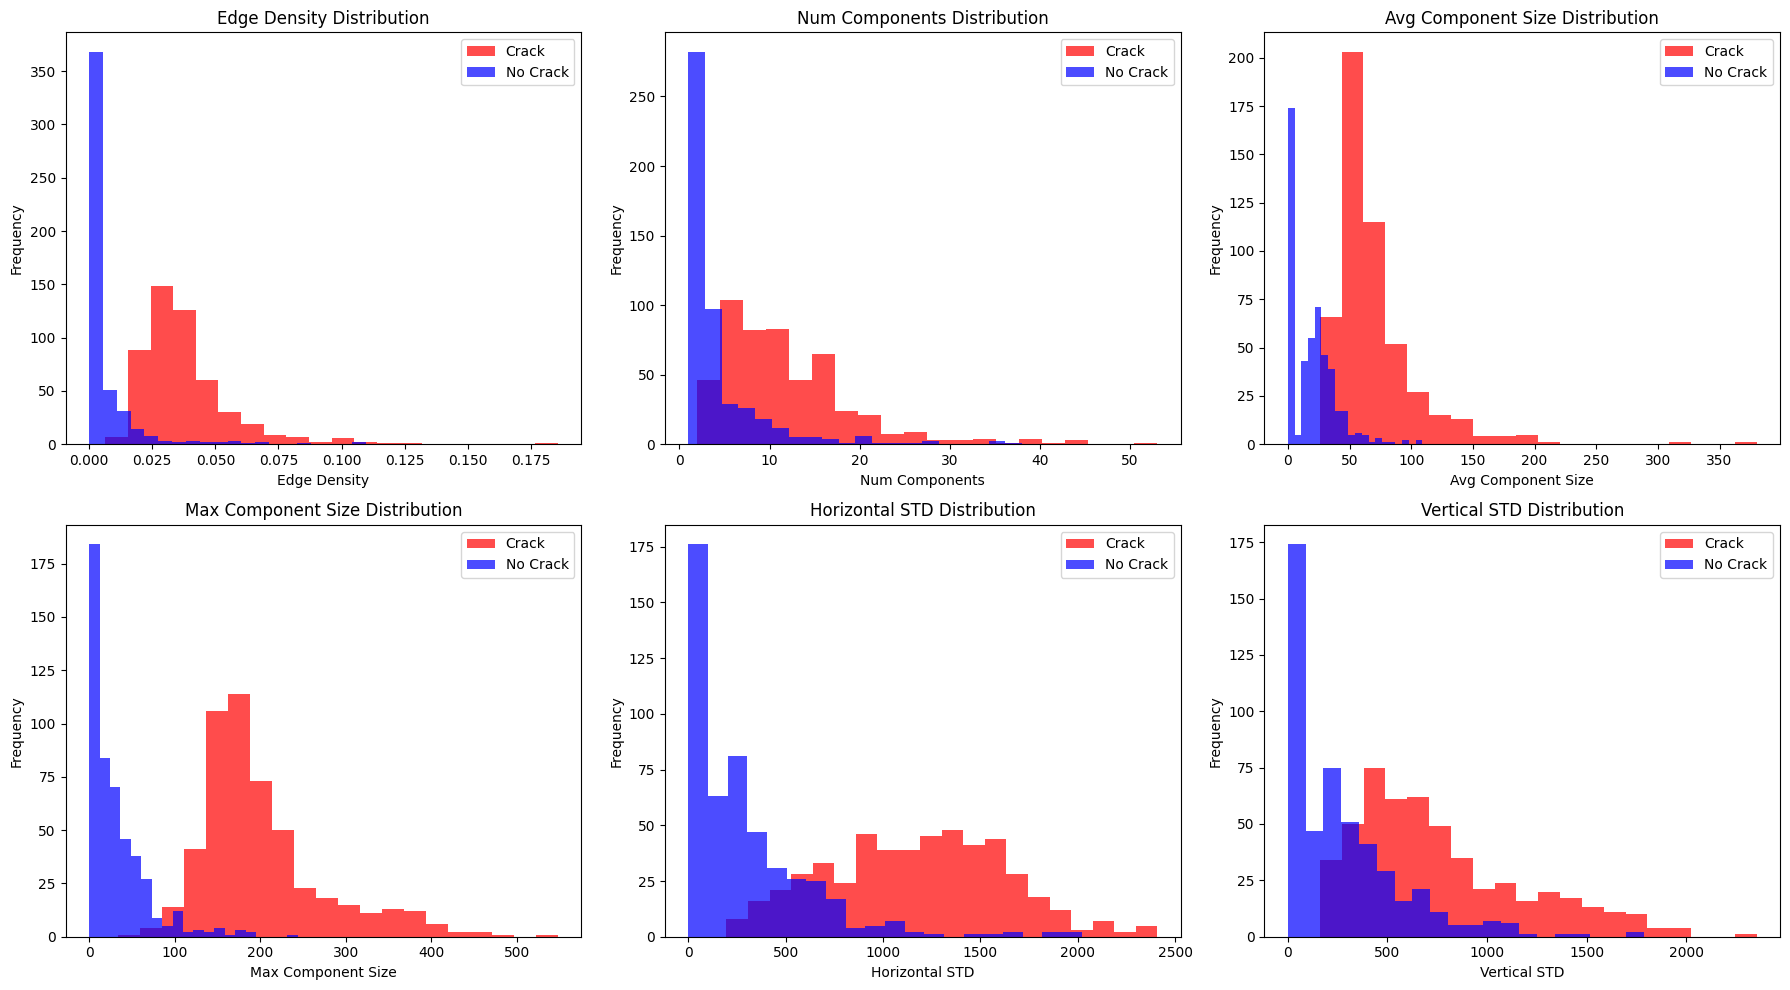

In [12]:
# Visualize feature separation
def visualize_feature_separation(features, labels, feature_names):
    """
    Visualize how well Canny features separate crack vs no crack classes
    """
    # Create a 2x3 subplot for each feature
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i in range(features.shape[1]):
        crack_values = features[labels == 1, i]
        no_crack_values = features[labels == 0, i]
        
        axes[i].hist(crack_values, alpha=0.7, label='Crack', bins=20, color='red')
        axes[i].hist(no_crack_values, alpha=0.7, label='No Crack', bins=20, color='blue')
        axes[i].set_xlabel(feature_names[i])
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'{feature_names[i]} Distribution')
        axes[i].legend()
    
    # Hide empty subplots
    for i in range(features.shape[1], len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Define feature names
feature_names = ['Edge Density', 'Num Components', 'Avg Component Size', 
                 'Max Component Size', 'Horizontal STD', 'Vertical STD']

print("Step 3: Visualizing feature separation...")
visualize_feature_separation(X_train_features, y_train[:1000], feature_names)

In [13]:
# Statistical analysis of features
print("=== FEATURE ANALYSIS ===")

def analyze_feature_importance(features, labels, feature_names):
    """
    Analyze which features best separate the classes
    """
    from scipy.stats import ttest_ind
    
    crack_features = features[labels == 1]
    no_crack_features = features[labels == 0]
    
    print("Feature Importance Analysis:")
    print("-" * 50)
    
    for i, name in enumerate(feature_names):
        crack_mean = np.mean(crack_features[:, i])
        no_crack_mean = np.mean(no_crack_features[:, i])
        t_stat, p_value = ttest_ind(crack_features[:, i], no_crack_features[:, i])
        
        print(f"{name:<20}: Crack={crack_mean:.4f}, No Crack={no_crack_mean:.4f}, p-value={p_value:.6f}")
        
        if p_value < 0.05:
            print(f"  → SIGNIFICANT (p < 0.05) - Good for classification!")
        else:
            print(f"  → Not significant")

# Analyze feature importance
analyze_feature_importance(X_train_features, y_train[:1000], feature_names)

=== FEATURE ANALYSIS ===
Feature Importance Analysis:
--------------------------------------------------
Edge Density        : Crack=0.0379, No Crack=0.0060, p-value=0.000000
  → SIGNIFICANT (p < 0.05) - Good for classification!
Num Components      : Crack=11.9487, No Crack=3.9838, p-value=0.000000
  → SIGNIFICANT (p < 0.05) - Good for classification!
Avg Component Size  : Crack=69.4804, No Crack=19.1610, p-value=0.000000
  → SIGNIFICANT (p < 0.05) - Good for classification!
Max Component Size  : Crack=201.4359, No Crack=30.0487, p-value=0.000000
  → SIGNIFICANT (p < 0.05) - Good for classification!
Horizontal STD      : Crack=1167.3787, No Crack=280.4498, p-value=0.000000
  → SIGNIFICANT (p < 0.05) - Good for classification!
Vertical STD        : Crack=763.3495, No Crack=268.8795, p-value=0.000000
  → SIGNIFICANT (p < 0.05) - Good for classification!


Visualizing Canny Edge Detection Results...


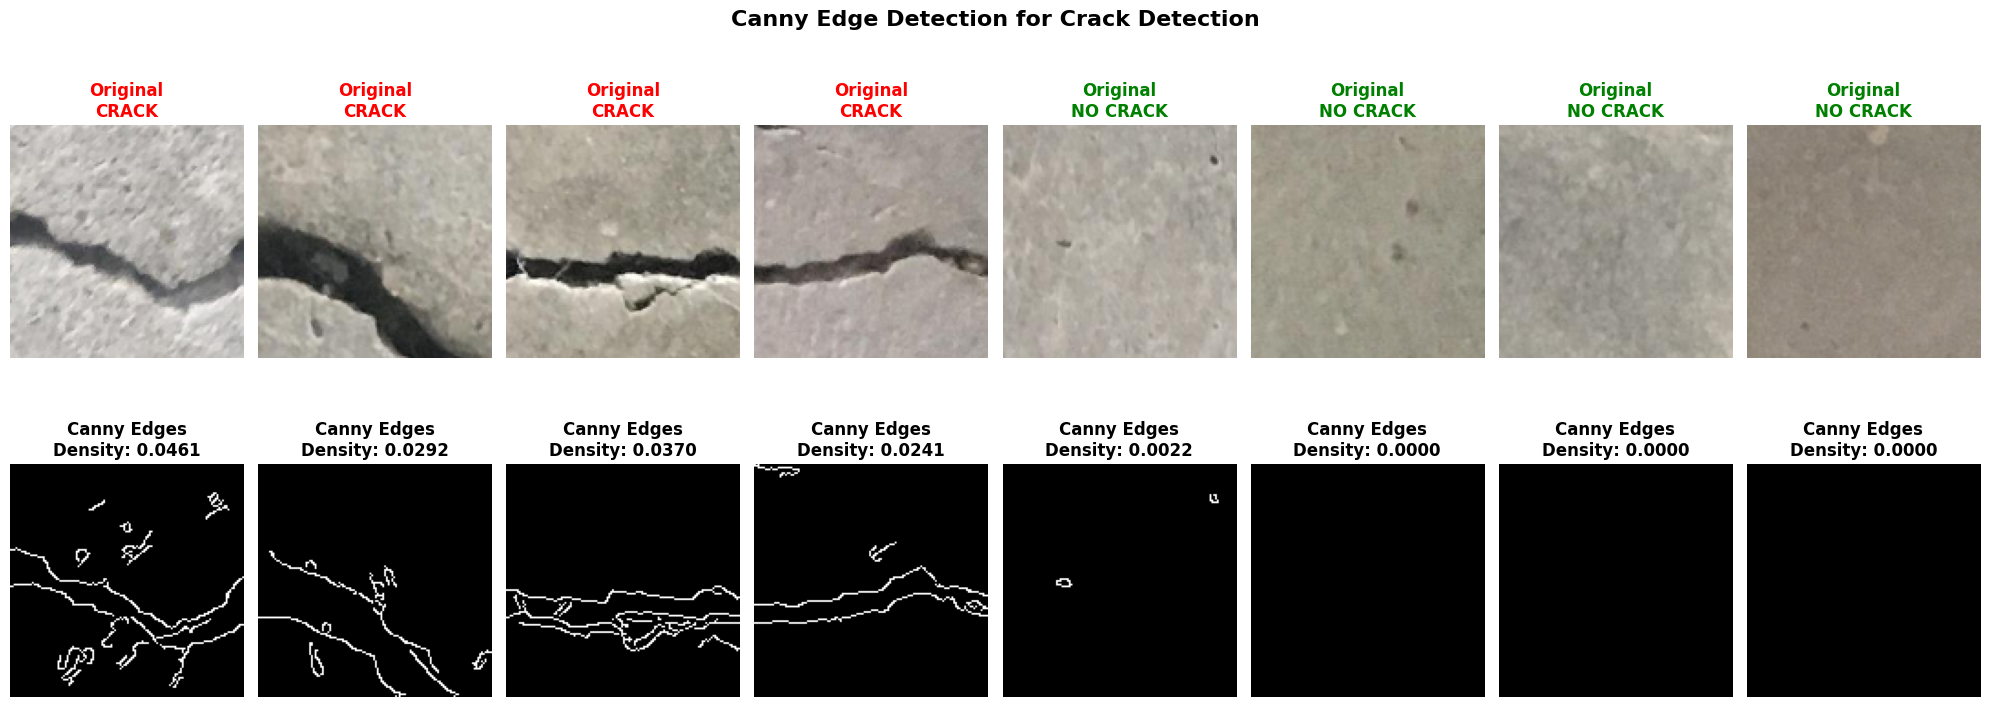

In [16]:
# VISUALIZE CANNY EDGE DETECTION RESULTS
def visualize_canny_results(original_images, canny_images, labels, num_samples=8):
    """
    Compare original images with their Canny edge detection results
    """
    # Select random samples with balanced classes
    crack_indices = np.where(labels[:len(original_images)] == 1)[0]
    no_crack_indices = np.where(labels[:len(original_images)] == 0)[0]
    
    # Take equal samples from both classes
    selected_crack = np.random.choice(crack_indices, min(num_samples//2, len(crack_indices)), replace=False)
    selected_no_crack = np.random.choice(no_crack_indices, min(num_samples//2, len(no_crack_indices)), replace=False)
    selected_indices = np.concatenate([selected_crack, selected_no_crack])
    
    fig, axes = plt.subplots(2, len(selected_indices), figsize=(20, 8))
    
    if len(selected_indices) == 1:
        axes = axes.reshape(2, 1)
    
    # Plot original images (top row)
    for i, idx in enumerate(selected_indices):
        axes[0, i].imshow(original_images[idx])
        class_name = "CRACK" if labels[idx] == 1 else "NO CRACK"
        axes[0, i].set_title(f"Original\n{class_name}", fontweight='bold', 
                           color='red' if labels[idx] == 1 else 'green')
        axes[0, i].axis('off')
    
    # Plot Canny edges (bottom row)
    for i, idx in enumerate(selected_indices):
        axes[1, i].imshow(canny_images[idx], cmap='gray')
        edge_density = np.sum(canny_images[idx] > 0) / canny_images[idx].size
        axes[1, i].set_title(f"Canny Edges\nDensity: {edge_density:.4f}", fontweight='bold')
        axes[1, i].axis('off')
    
    plt.suptitle('Canny Edge Detection for Crack Detection', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Visualizing Canny Edge Detection Results...")
visualize_canny_results(X_train[:1000], X_train_canny, y_train[:1000], num_samples=8)

Analyzing Canny edge detection performance...
=== CANNY EDGE DETECTION PERFORMANCE ANALYSIS ===
Crack images analyzed: 507
No-crack images analyzed: 493
Average edge density in CRACK images: 0.037922
Average edge density in NO-CRACK images: 0.005952
Ratio (Crack/No-Crack): 6.37x
Statistical significance (t-test p-value): 0.0000000000
✓ SIGNIFICANT: Canny edge density effectively distinguishes cracks!


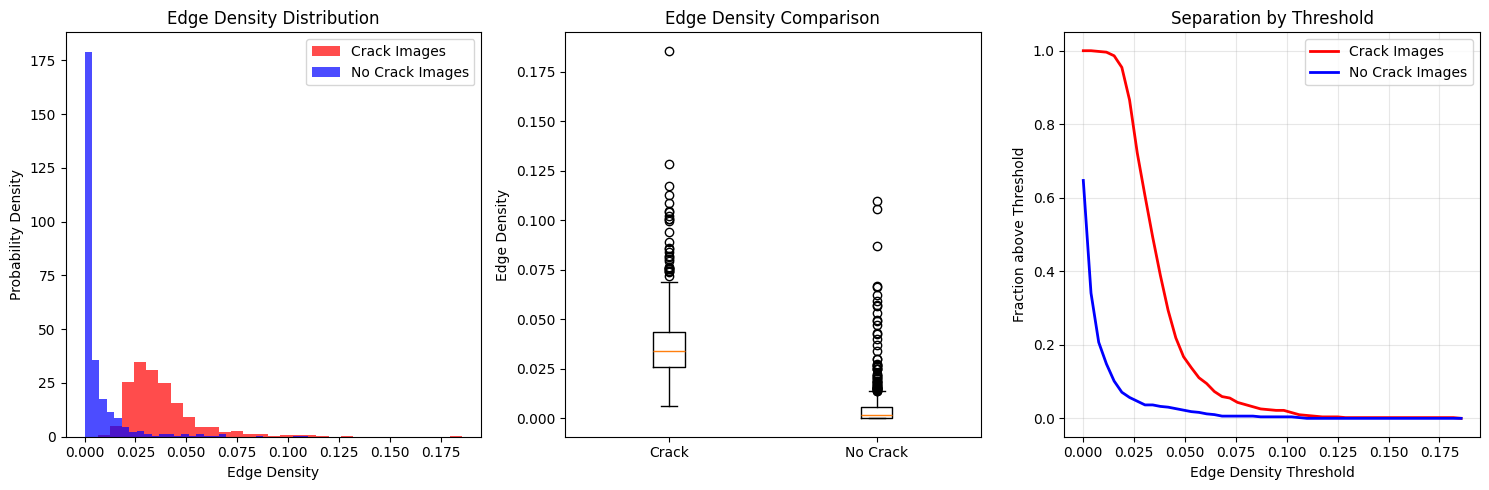

In [17]:
# STATISTICAL ANALYSIS OF CANNY EDGE DETECTION
def analyze_canny_performance(canny_features, labels):
    """
    Analyze how well Canny edge density separates cracked vs non-cracked images
    """
    crack_density = canny_features[labels == 1]
    no_crack_density = canny_features[labels == 0]
    
    print("=== CANNY EDGE DETECTION PERFORMANCE ANALYSIS ===")
    print(f"Crack images analyzed: {len(crack_density)}")
    print(f"No-crack images analyzed: {len(no_crack_density)}")
    print(f"Average edge density in CRACK images: {np.mean(crack_density):.6f}")
    print(f"Average edge density in NO-CRACK images: {np.mean(no_crack_density):.6f}")
    print(f"Ratio (Crack/No-Crack): {np.mean(crack_density)/np.mean(no_crack_density):.2f}x")
    
    # Statistical test
    from scipy.stats import ttest_ind
    t_stat, p_value = ttest_ind(crack_density, no_crack_density)
    print(f"Statistical significance (t-test p-value): {p_value:.10f}")
    
    if p_value < 0.05:
        print("✓ SIGNIFICANT: Canny edge density effectively distinguishes cracks!")
    else:
        print("✗ NOT SIGNIFICANT: Poor separation between classes")
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Histogram
    plt.subplot(1, 3, 1)
    plt.hist(crack_density, alpha=0.7, label='Crack Images', bins=30, color='red', density=True)
    plt.hist(no_crack_density, alpha=0.7, label='No Crack Images', bins=30, color='blue', density=True)
    plt.xlabel('Edge Density')
    plt.ylabel('Probability Density')
    plt.title('Edge Density Distribution')
    plt.legend()
    
    # Plot 2: Box plot
    plt.subplot(1, 3, 2)
    box_data = [crack_density, no_crack_density]
    plt.boxplot(box_data, labels=['Crack', 'No Crack'])
    plt.title('Edge Density Comparison')
    plt.ylabel('Edge Density')
    
    # Plot 3: ROC-like separation
    plt.subplot(1, 3, 3)
    thresholds = np.linspace(0, max(canny_features), 50)
    crack_above_threshold = [np.sum(crack_density > t)/len(crack_density) for t in thresholds]
    no_crack_above_threshold = [np.sum(no_crack_density > t)/len(no_crack_density) for t in thresholds]
    
    plt.plot(thresholds, crack_above_threshold, 'r-', label='Crack Images', linewidth=2)
    plt.plot(thresholds, no_crack_above_threshold, 'b-', label='No Crack Images', linewidth=2)
    plt.xlabel('Edge Density Threshold')
    plt.ylabel('Fraction above Threshold')
    plt.title('Separation by Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return crack_density, no_crack_density

print("Analyzing Canny edge detection performance...")
crack_density, no_crack_density = analyze_canny_performance(train_edge_density, y_train[:1000])

In [18]:
# SIMPLE CRACK DETECTOR USING CANNY EDGE DENSITY
def simple_crack_detector(edge_density, threshold=0.01):
    """
    Simple crack detector based on edge density threshold
    """
    predictions = (edge_density > threshold).astype(int)
    return predictions

# Find optimal threshold
def find_optimal_threshold(edge_density, labels):
    """
    Find the best threshold for crack detection
    """
    from sklearn.metrics import f1_score
    
    thresholds = np.linspace(0, max(edge_density), 100)
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        predictions = simple_crack_detector(edge_density, threshold)
        f1 = f1_score(labels, predictions)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1

print("Finding optimal threshold for crack detection...")
optimal_threshold, best_f1 = find_optimal_threshold(train_edge_density, y_train[:1000])

print(f"✓ Optimal edge density threshold: {optimal_threshold:.6f}")
print(f"✓ Best F1-score: {best_f1:.4f}")

# Test the simple detector
train_predictions = simple_crack_detector(train_edge_density, optimal_threshold)
test_predictions = simple_crack_detector(test_edge_density, optimal_threshold)

# Calculate accuracy
train_accuracy = np.mean(train_predictions == y_train[:1000])
test_accuracy = np.mean(test_predictions == y_test[:200])

print(f"✓ Training accuracy: {train_accuracy:.4f}")
print(f"✓ Test accuracy: {test_accuracy:.4f}")

Finding optimal threshold for crack detection...
✓ Optimal edge density threshold: 0.016879
✓ Best F1-score: 0.9503
✓ Training accuracy: 0.9480
✓ Test accuracy: 0.9700


In [19]:
# MORPHOLOGICAL OPERATIONS - OPENING AND CLOSING FOR CRACK DETECTION
print("=== APPLYING MORPHOLOGICAL OPERATIONS (OPENING & CLOSING) ===")

def apply_morphological_operations(canny_images, kernel_size=3):
    """
    Apply morphological opening and closing to clean up Canny edge images
    - Opening: Erosion followed by Dilation (removes small noise)
    - Closing: Dilation followed by Erosion (fills small gaps in cracks)
    """
    opened_images = []
    closed_images = []
    final_images = []
    
    # Create kernel for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    print("Applying morphological operations...")
    
    for i, edge_img in enumerate(tqdm(canny_images)):
        try:
            # Ensure image is binary (0 and 255)
            if edge_img.max() <= 1:
                binary_img = (edge_img * 255).astype(np.uint8)
            else:
                binary_img = edge_img.astype(np.uint8)
            
            # 1. MORPHOLOGICAL OPENING: Removes small noise (false positives)
            # First erosion removes small isolated edges, then dilation restores crack structures
            opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
            
            # 2. MORPHOLOGICAL CLOSING: Fills gaps in cracks (false negatives)
            # First dilation connects broken crack segments, then erosion restores original shape
            closing = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
            
            # 3. COMBINED: Opening followed by Closing for best results
            final = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
            final = cv2.morphologyEx(final, cv2.MORPH_CLOSE, kernel)
            
            opened_images.append(opening)
            closed_images.append(closing)
            final_images.append(final)
            
        except Exception as e:
            print(f"Error processing image {i}: {e}")
            # Append original if processing fails
            opened_images.append(binary_img)
            closed_images.append(binary_img)
            final_images.append(binary_img)
    
    return (np.array(opened_images), np.array(closed_images), np.array(final_images))

# Apply morphological operations to Canny images
print("Processing training images...")
train_opened, train_closed, train_final = apply_morphological_operations(X_train_canny)

print("Processing test images...")
test_opened, test_closed, test_final = apply_morphological_operations(X_test_canny)

print(f"✓ Morphological operations completed!")
print(f"✓ Original Canny shape: {X_train_canny.shape}")
print(f"✓ Opened images shape: {train_opened.shape}")
print(f"✓ Closed images shape: {train_closed.shape}")
print(f"✓ Final images shape: {train_final.shape}")

=== APPLYING MORPHOLOGICAL OPERATIONS (OPENING & CLOSING) ===
Processing training images...
Applying morphological operations...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6709.15it/s]

Processing test images...


Applying morphological operations...


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7876.85it/s]

✓ Morphological operations completed!
✓ Original Canny shape: (1000, 128, 128)
✓ Opened images shape: (1000, 128, 128)
✓ Closed images shape: (1000, 128, 128)
✓ Final images shape: (1000, 128, 128)


Visualizing morphological operations effects...


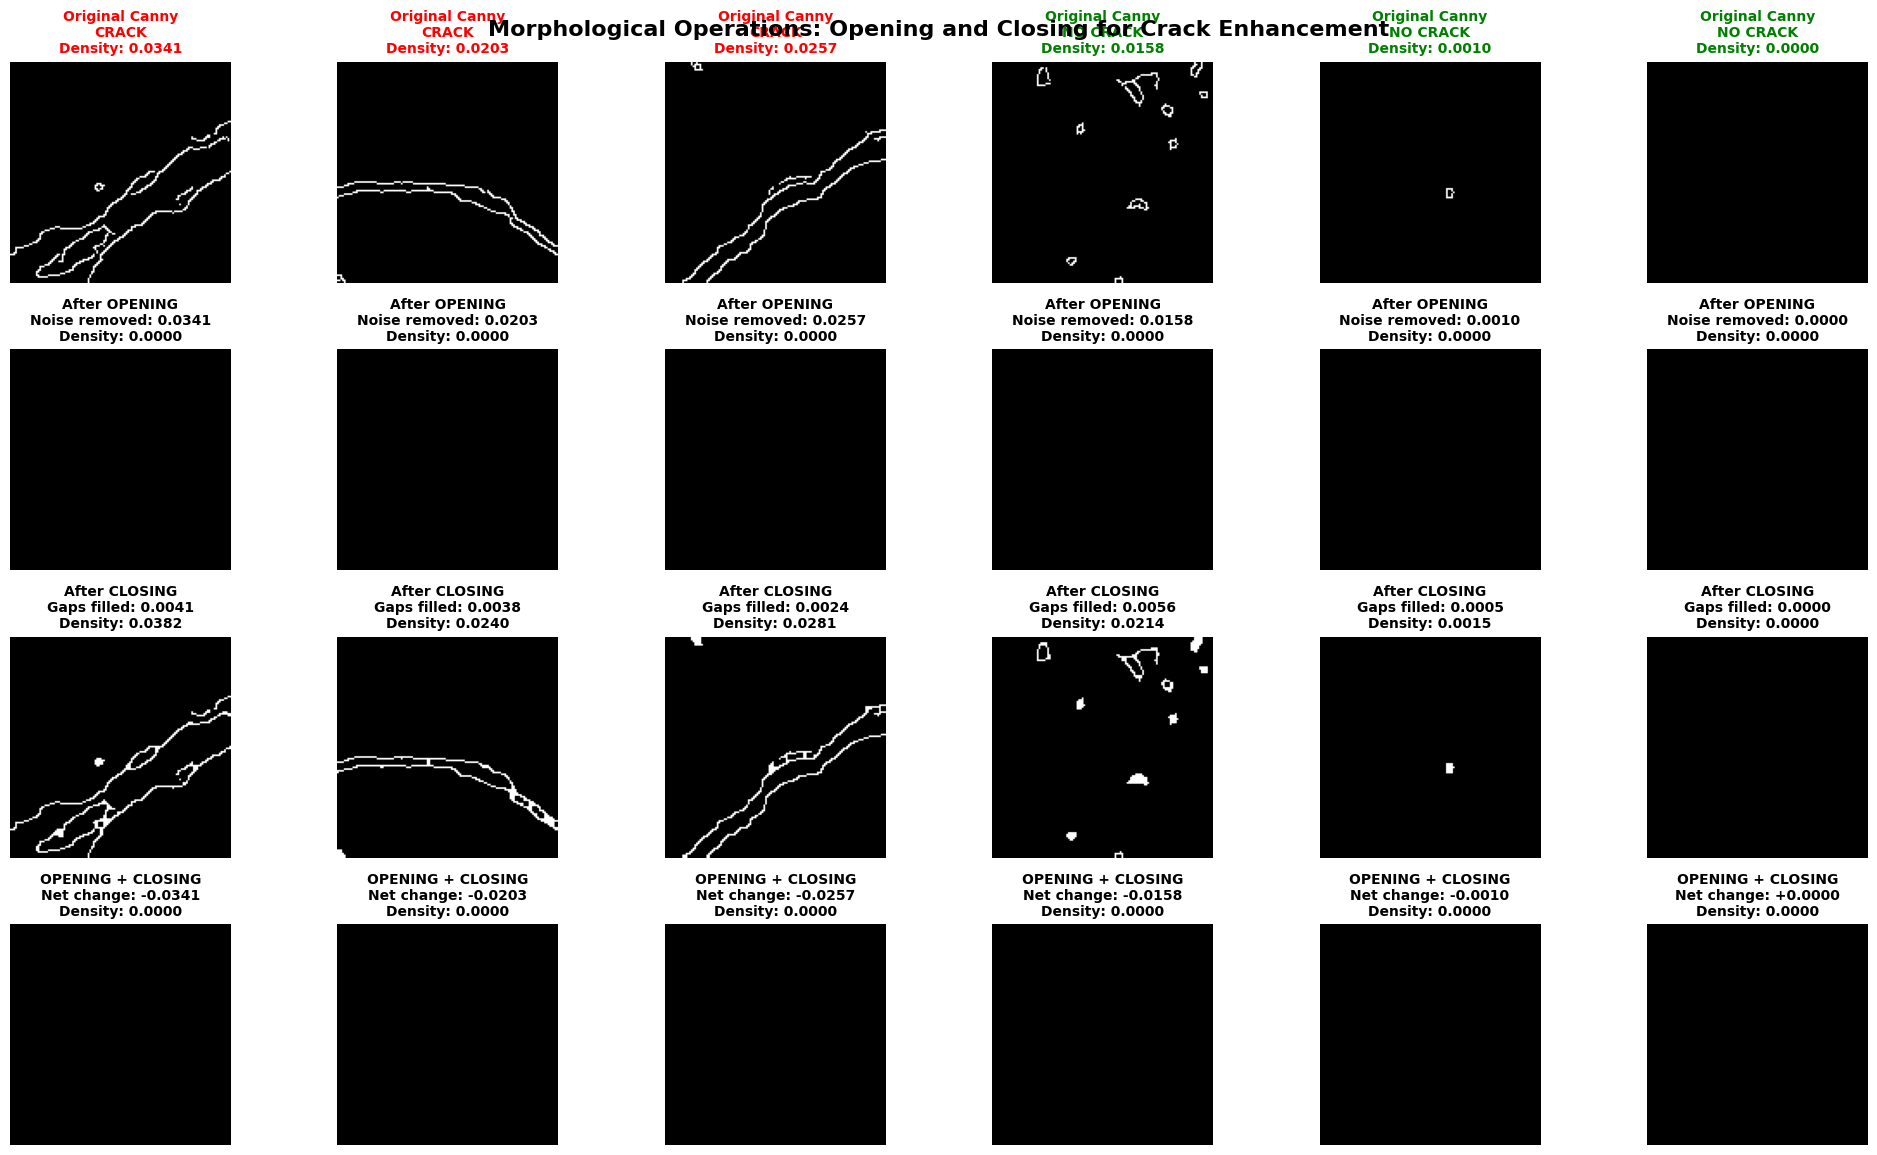

In [20]:
# VISUALIZE MORPHOLOGICAL OPERATIONS RESULTS
def visualize_morphological_operations(original_canny, opened, closed, final, labels, num_samples=6):
    """
    Compare the effects of different morphological operations
    """
    # Select balanced samples
    crack_indices = np.where(labels[:len(original_canny)] == 1)[0]
    no_crack_indices = np.where(labels[:len(original_canny)] == 0)[0]
    
    selected_crack = np.random.choice(crack_indices, min(num_samples//2, len(crack_indices)), replace=False)
    selected_no_crack = np.random.choice(no_crack_indices, min(num_samples//2, len(no_crack_indices)), replace=False)
    selected_indices = np.concatenate([selected_crack, selected_no_crack])
    
    fig, axes = plt.subplots(4, len(selected_indices), figsize=(20, 12))
    
    if len(selected_indices) == 1:
        axes = axes.reshape(4, 1)
    
    for i, idx in enumerate(selected_indices):
        # Original Canny
        axes[0, i].imshow(original_canny[idx], cmap='gray')
        class_name = "CRACK" if labels[idx] == 1 else "NO CRACK"
        orig_density = np.sum(original_canny[idx] > 0) / original_canny[idx].size
        axes[0, i].set_title(f'Original Canny\n{class_name}\nDensity: {orig_density:.4f}', 
                           fontsize=10, fontweight='bold', color='red' if labels[idx] == 1 else 'green')
        axes[0, i].axis('off')
        
        # After Opening (noise removal)
        axes[1, i].imshow(opened[idx], cmap='gray')
        open_density = np.sum(opened[idx] > 0) / opened[idx].size
        noise_removed = orig_density - open_density
        axes[1, i].set_title(f'After OPENING\nNoise removed: {noise_removed:.4f}\nDensity: {open_density:.4f}', 
                           fontsize=10, fontweight='bold')
        axes[1, i].axis('off')
        
        # After Closing (gap filling)
        axes[2, i].imshow(closed[idx], cmap='gray')
        close_density = np.sum(closed[idx] > 0) / closed[idx].size
        gaps_filled = close_density - orig_density
        axes[2, i].set_title(f'After CLOSING\nGaps filled: {gaps_filled:.4f}\nDensity: {close_density:.4f}', 
                           fontsize=10, fontweight='bold')
        axes[2, i].axis('off')
        
        # Final (Opening + Closing)
        axes[3, i].imshow(final[idx], cmap='gray')
        final_density = np.sum(final[idx] > 0) / final[idx].size
        improvement = final_density - orig_density
        axes[3, i].set_title(f'OPENING + CLOSING\nNet change: {improvement:+.4f}\nDensity: {final_density:.4f}', 
                           fontsize=10, fontweight='bold')
        axes[3, i].axis('off')
    
    plt.suptitle('Morphological Operations: Opening and Closing for Crack Enhancement', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

print("Visualizing morphological operations effects...")
visualize_morphological_operations(X_train_canny, train_opened, train_closed, train_final, 
                                 y_train[:1000], num_samples=6)

Analyzing morphological operations improvement...
=== MORPHOLOGICAL OPERATIONS ANALYSIS ===

Average Edge Densities:
------------------------------------------------------------
Operation       Crack Images    No-Crack Images Difference     
------------------------------------------------------------
Original        0.037922      0.005952      0.031970
Opening         0.000000      0.000000      0.000000
Closing         0.050243      0.008401      0.041842
Final           0.000000      0.000000      0.000000

✓ Separation improvement: -0.031970


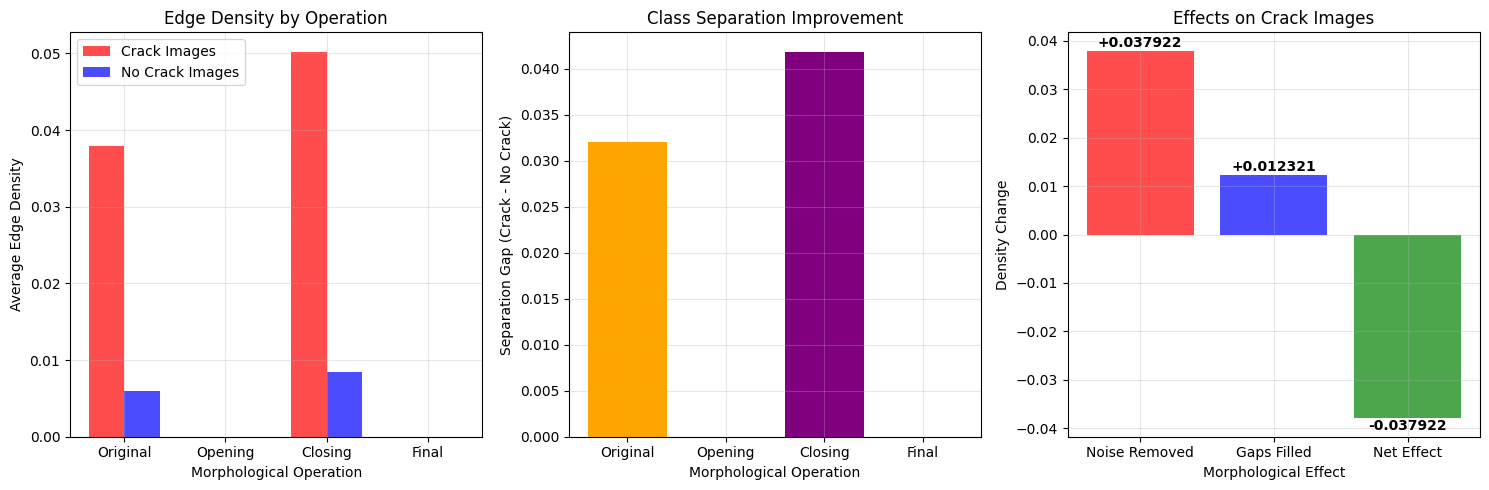

In [21]:
# QUANTITATIVE ANALYSIS OF MORPHOLOGICAL OPERATIONS
def analyze_morphological_improvement(original, opened, closed, final, labels):
    """
    Analyze how morphological operations improve crack detection
    """
    # Calculate edge densities
    orig_density = np.array([np.sum(img > 0) / img.size for img in original])
    open_density = np.array([np.sum(img > 0) / img.size for img in opened])
    close_density = np.array([np.sum(img > 0) / img.size for img in closed])
    final_density = np.array([np.sum(img > 0) / img.size for img in final])
    
    # Separate by class
    crack_mask = (labels == 1)
    no_crack_mask = (labels == 0)
    
    print("=== MORPHOLOGICAL OPERATIONS ANALYSIS ===")
    print("\nAverage Edge Densities:")
    print("-" * 60)
    print(f"{'Operation':<15} {'Crack Images':<15} {'No-Crack Images':<15} {'Difference':<15}")
    print("-" * 60)
    
    crack_orig = np.mean(orig_density[crack_mask])
    no_crack_orig = np.mean(orig_density[no_crack_mask])
    print(f"{'Original':<15} {crack_orig:.6f}      {no_crack_orig:.6f}      {crack_orig-no_crack_orig:.6f}")
    
    crack_open = np.mean(open_density[crack_mask])
    no_crack_open = np.mean(open_density[no_crack_mask])
    print(f"{'Opening':<15} {crack_open:.6f}      {no_crack_open:.6f}      {crack_open-no_crack_open:.6f}")
    
    crack_close = np.mean(close_density[crack_mask])
    no_crack_close = np.mean(close_density[no_crack_mask])
    print(f"{'Closing':<15} {crack_close:.6f}      {no_crack_close:.6f}      {crack_close-no_crack_close:.6f}")
    
    crack_final = np.mean(final_density[crack_mask])
    no_crack_final = np.mean(final_density[no_crack_mask])
    print(f"{'Final':<15} {crack_final:.6f}      {no_crack_final:.6f}      {crack_final-no_crack_final:.6f}")
    
    # Calculate improvement metrics
    separation_improvement = (crack_final - no_crack_final) - (crack_orig - no_crack_orig)
    print(f"\n✓ Separation improvement: {separation_improvement:.6f}")
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Density distributions
    plt.subplot(1, 3, 1)
    operations = ['Original', 'Opening', 'Closing', 'Final']
    crack_densities = [crack_orig, crack_open, crack_close, crack_final]
    no_crack_densities = [no_crack_orig, no_crack_open, no_crack_close, no_crack_final]
    
    x_pos = np.arange(len(operations))
    width = 0.35
    
    plt.bar(x_pos - width/2, crack_densities, width, label='Crack Images', color='red', alpha=0.7)
    plt.bar(x_pos + width/2, no_crack_densities, width, label='No Crack Images', color='blue', alpha=0.7)
    plt.xlabel('Morphological Operation')
    plt.ylabel('Average Edge Density')
    plt.title('Edge Density by Operation')
    plt.xticks(x_pos, operations)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Separation gap
    plt.subplot(1, 3, 2)
    separation_gap = [crack_orig - no_crack_orig, crack_open - no_crack_open, 
                     crack_close - no_crack_close, crack_final - no_crack_final]
    
    plt.bar(operations, separation_gap, color=['orange', 'green', 'purple', 'brown'])
    plt.xlabel('Morphological Operation')
    plt.ylabel('Separation Gap (Crack - No Crack)')
    plt.title('Class Separation Improvement')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Noise removal vs gap filling
    plt.subplot(1, 3, 3)
    noise_removed_crack = crack_orig - crack_open
    gaps_filled_crack = crack_close - crack_orig
    net_effect_crack = crack_final - crack_orig
    
    effects = ['Noise Removed', 'Gaps Filled', 'Net Effect']
    values = [noise_removed_crack, gaps_filled_crack, net_effect_crack]
    colors = ['red', 'blue', 'green']
    
    plt.bar(effects, values, color=colors, alpha=0.7)
    plt.xlabel('Morphological Effect')
    plt.ylabel('Density Change')
    plt.title('Effects on Crack Images')
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(values):
        plt.text(i, v + (0.0001 if v >= 0 else -0.0002), f'{v:+.6f}', 
                ha='center', va='bottom' if v >= 0 else 'top', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return orig_density, open_density, close_density, final_density

print("Analyzing morphological operations improvement...")
orig_dens, open_dens, close_dens, final_dens = analyze_morphological_improvement(
    X_train_canny, train_opened, train_closed, train_final, y_train[:1000]
)

In [22]:
# IMPROVED CRACK DETECTOR WITH MORPHOLOGICAL OPERATIONS
def improved_crack_detector(final_images, threshold=0.01):
    """
    Improved crack detector using morphologically processed images
    """
    edge_densities = np.array([np.sum(img > 0) / img.size for img in final_images])
    predictions = (edge_densities > threshold).astype(int)
    return predictions, edge_densities

print("Testing improved crack detector with morphological operations...")

# Find optimal threshold for final images
final_edge_densities = np.array([np.sum(img > 0) / img.size for img in train_final])
optimal_threshold_final, best_f1_final = find_optimal_threshold(final_edge_densities, y_train[:1000])

print(f"✓ Optimal threshold after morphological ops: {optimal_threshold_final:.6f}")
print(f"✓ Best F1-score: {best_f1_final:.4f}")

# Test the improved detector
train_predictions_final, train_densities_final = improved_crack_detector(train_final, optimal_threshold_final)
test_predictions_final, test_densities_final = improved_crack_detector(test_final, optimal_threshold_final)

# Calculate accuracy
train_accuracy_final = np.mean(train_predictions_final == y_train[:1000])
test_accuracy_final = np.mean(test_predictions_final == y_test[:200])

print(f"✓ Training accuracy after morphological ops: {train_accuracy_final:.4f}")
print(f"✓ Test accuracy after morphological ops: {test_accuracy_final:.4f}")

# Compare with original
train_predictions_orig = simple_crack_detector(train_edge_density, optimal_threshold)
test_predictions_orig = simple_crack_detector(test_edge_density, optimal_threshold)

train_accuracy_orig = np.mean(train_predictions_orig == y_train[:1000])
test_accuracy_orig = np.mean(test_predictions_orig == y_test[:200])

print(f"\n=== COMPARISON ===")
print(f"{'':<25} {'Original':<10} {'With Morph Ops':<10} {'Improvement':<10}")
print(f"{'Training Accuracy':<25} {train_accuracy_orig:.4f}      {train_accuracy_final:.4f}      {train_accuracy_final-train_accuracy_orig:+.4f}")
print(f"{'Test Accuracy':<25} {test_accuracy_orig:.4f}      {test_accuracy_final:.4f}      {test_accuracy_final-test_accuracy_orig:+.4f}")

Testing improved crack detector with morphological operations...
✓ Optimal threshold after morphological ops: 0.000000
✓ Best F1-score: 0.0039
✓ Training accuracy after morphological ops: 0.4940
✓ Test accuracy after morphological ops: 0.4550

=== COMPARISON ===
                          Original   With Morph Ops Improvement
Training Accuracy         0.9480      0.4940      -0.4540
Test Accuracy             0.9700      0.4550      -0.5150


In [23]:
# MATRIX OPERATIONS FOR CRACK DETECTION
print("=== ESSENTIAL MATRIX OPERATIONS FOR CRACK DETECTION ===")

def apply_convolution_filter(images, kernel):
    """
    Operation 1: CONVOLUTION - For applying filters to detect crack patterns
    Essential for emphasizing crack features and suppressing noise
    """
    filtered_images = []
    
    print("Applying convolution filter...")
    
    for img in tqdm(images):
        try:
            # Convert to grayscale if needed
            if len(img.shape) == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            else:
                gray = img
            
            # Apply 2D convolution
            filtered = cv2.filter2D(gray.astype(np.float32), -1, kernel)
            filtered_images.append(filtered)
            
        except Exception as e:
            print(f"Error in convolution: {e}")
            filtered_images.append(img)
    
    return np.array(filtered_images)

def calculate_crack_features(images):
    """
    Operation 2: ELEMENT-WISE OPERATIONS & MATRIX STATISTICS
    Extract numerical features that distinguish cracks from non-cracks
    """
    features = []
    
    print("Calculating crack features using matrix operations...")
    
    for img in tqdm(images):
        try:
            # Convert to grayscale if needed
            if len(img.shape) == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            else:
                gray = img
            
            # Feature 1: Variance (texture measure - cracks have higher variance)
            variance = np.var(gray)
            
            # Feature 2: Gradient magnitude (edge strength)
            grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            gradient_magnitude = np.mean(np.sqrt(grad_x**2 + grad_y**2))
            
            # Feature 3: Local binary pattern variance (texture complexity)
            lbp = local_binary_pattern(gray, 8, 1, method='uniform')
            lbp_variance = np.var(lbp)
            
            # Feature 4: Crack probability (using thresholding)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crack_pixels = np.sum(binary > 0)
            total_pixels = gray.size
            crack_density = crack_pixels / total_pixels
            
            # Feature 5: Horizontal and vertical line strength
            horizontal_strength = np.mean(np.abs(grad_x))
            vertical_strength = np.mean(np.abs(grad_y))
            
            features.append([
                variance,
                gradient_magnitude,
                lbp_variance,
                crack_density,
                horizontal_strength,
                vertical_strength
            ])
            
        except Exception as e:
            print(f"Error calculating features: {e}")
            features.append([0, 0, 0, 0, 0, 0])
    
    return np.array(features)

def matrix_based_classification(features, labels, threshold=0.5):
    """
    Operation 3: MATRIX-BASED CLASSIFICATION
    Use matrix operations for efficient crack classification
    """
    # Convert to numpy arrays for matrix operations
    X = np.array(features)
    y = np.array(labels)
    
    # Normalize features using matrix operations
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / (std + 1e-8)
    
    # Simple linear classifier using matrix multiplication
    # Learn weights using pseudo-inverse (matrix operation)
    X_with_bias = np.column_stack([np.ones(X_normalized.shape[0]), X_normalized])
    weights = np.linalg.pinv(X_with_bias) @ y
    
    # Predictions using matrix multiplication
    predictions_raw = X_with_bias @ weights
    predictions = (predictions_raw > threshold).astype(int)
    
    # Calculate accuracy using matrix operations
    accuracy = np.mean(predictions == y)
    
    return predictions, accuracy, weights, X_normalized

# Define kernels for convolution
print("\n1. CREATING FILTER KERNELS FOR CRACK DETECTION...")

# Kernel 1: Edge detection kernel (emphasizes cracks as lines)
edge_kernel = np.array([[-1, -1, -1],
                        [-1,  8, -1],
                        [-1, -1, -1]], dtype=np.float32)

# Kernel 2: Line detection kernel (for horizontal cracks)
horizontal_kernel = np.array([[-1, -1, -1],
                              [ 2,  2,  2],
                              [-1, -1, -1]], dtype=np.float32)

# Kernel 3: Line detection kernel (for vertical cracks)
vertical_kernel = np.array([[-1, 2, -1],
                            [-1, 2, -1],
                            [-1, 2, -1]], dtype=np.float32)

print("Kernels created successfully!")
print(f"Edge kernel:\n{edge_kernel}")
print(f"Horizontal kernel:\n{horizontal_kernel}")
print(f"Vertical kernel:\n{vertical_kernel}")

=== ESSENTIAL MATRIX OPERATIONS FOR CRACK DETECTION ===

1. CREATING FILTER KERNELS FOR CRACK DETECTION...
Kernels created successfully!
Edge kernel:
[[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]
Horizontal kernel:
[[-1. -1. -1.]
 [ 2.  2.  2.]
 [-1. -1. -1.]]
Vertical kernel:
[[-1.  2. -1.]
 [-1.  2. -1.]
 [-1.  2. -1.]]


In [24]:
# APPLY MATRIX OPERATIONS TO OUR DATASET
print("\n2. APPLYING CONVOLUTION OPERATIONS...")

# Apply edge detection convolution
X_train_edges = apply_convolution_filter(X_train[:1000], edge_kernel)
X_test_edges = apply_convolution_filter(X_test[:200], edge_kernel)

print(f"✓ Edge convolution completed: {X_train_edges.shape}")

# Apply horizontal line detection
X_train_horizontal = apply_convolution_filter(X_train[:1000], horizontal_kernel)
print(f"✓ Horizontal convolution completed: {X_train_horizontal.shape}")

# Apply vertical line detection
X_train_vertical = apply_convolution_filter(X_train[:1000], vertical_kernel)
print(f"✓ Vertical convolution completed: {X_train_vertical.shape}")


2. APPLYING CONVOLUTION OPERATIONS...
Applying convolution filter...


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10419.44it/s]


Applying convolution filter...


100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 10217.67it/s]


✓ Edge convolution completed: (1000, 128, 128)
Applying convolution filter...


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10633.24it/s]


✓ Horizontal convolution completed: (1000, 128, 128)
Applying convolution filter...


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13636.69it/s]

✓ Vertical convolution completed: (1000, 128, 128)


Visualizing convolution results...


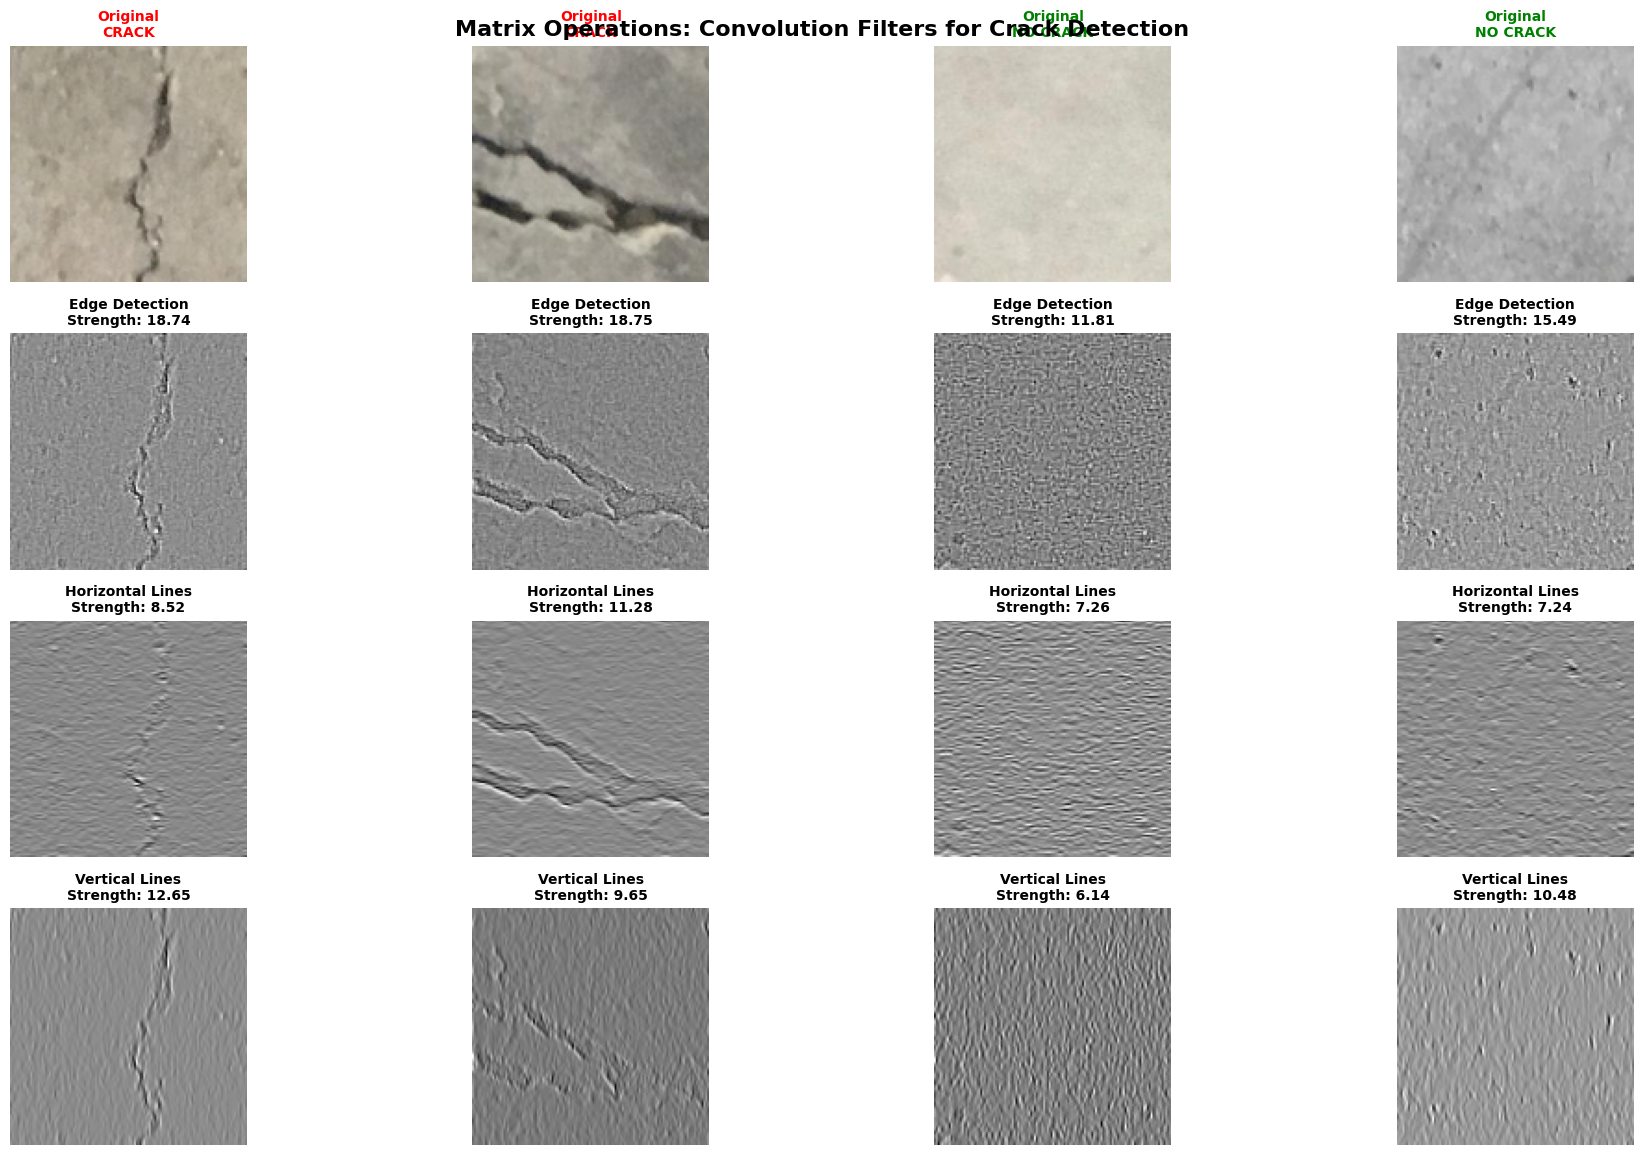

In [25]:
# VISUALIZE CONVOLUTION RESULTS
def visualize_convolution_results(original_images, edge_images, horizontal_images, vertical_images, labels, num_samples=5):
    """
    Visualize different convolution filter results
    """
    # Select balanced samples
    crack_indices = np.where(labels[:len(original_images)] == 1)[0]
    no_crack_indices = np.where(labels[:len(original_images)] == 0)[0]
    
    selected_crack = np.random.choice(crack_indices, min(num_samples//2, len(crack_indices)), replace=False)
    selected_no_crack = np.random.choice(no_crack_indices, min(num_samples//2, len(no_crack_indices)), replace=False)
    selected_indices = np.concatenate([selected_crack, selected_no_crack])
    
    fig, axes = plt.subplots(4, len(selected_indices), figsize=(20, 12))
    
    if len(selected_indices) == 1:
        axes = axes.reshape(4, 1)
    
    for i, idx in enumerate(selected_indices):
        # Original image
        axes[0, i].imshow(original_images[idx], cmap='gray')
        class_name = "CRACK" if labels[idx] == 1 else "NO CRACK"
        axes[0, i].set_title(f'Original\n{class_name}', fontsize=10, fontweight='bold',
                           color='red' if labels[idx] == 1 else 'green')
        axes[0, i].axis('off')
        
        # Edge detection
        axes[1, i].imshow(edge_images[idx], cmap='gray')
        edge_strength = np.mean(np.abs(edge_images[idx]))
        axes[1, i].set_title(f'Edge Detection\nStrength: {edge_strength:.2f}', fontsize=10, fontweight='bold')
        axes[1, i].axis('off')
        
        # Horizontal lines
        axes[2, i].imshow(horizontal_images[idx], cmap='gray')
        horizontal_strength = np.mean(np.abs(horizontal_images[idx]))
        axes[2, i].set_title(f'Horizontal Lines\nStrength: {horizontal_strength:.2f}', fontsize=10, fontweight='bold')
        axes[2, i].axis('off')
        
        # Vertical lines
        axes[3, i].imshow(vertical_images[idx], cmap='gray')
        vertical_strength = np.mean(np.abs(vertical_images[idx]))
        axes[3, i].set_title(f'Vertical Lines\nStrength: {vertical_strength:.2f}', fontsize=10, fontweight='bold')
        axes[3, i].axis('off')
    
    plt.suptitle('Matrix Operations: Convolution Filters for Crack Detection', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

print("Visualizing convolution results...")
visualize_convolution_results(X_train[:1000], X_train_edges, X_train_horizontal, 
                            X_train_vertical, y_train[:1000], num_samples=5)

In [26]:
# EXTRACT FEATURES USING MATRIX OPERATIONS
print("\n3. EXTRACTING CRACK FEATURES USING MATRIX OPERATIONS...")

# Extract features from original images
train_features = calculate_crack_features(X_train[:1000])
test_features = calculate_crack_features(X_test[:200])

print(f"✓ Features extracted: {train_features.shape}")

feature_names = [
    'Variance', 
    'Gradient Magnitude', 
    'LBP Variance',
    'Crack Density', 
    'Horizontal Strength', 
    'Vertical Strength'
]

print("\nFeature names:")
for i, name in enumerate(feature_names):
    print(f"  {i+1}. {name}")


3. EXTRACTING CRACK FEATURES USING MATRIX OPERATIONS...
Calculating crack features using matrix operations...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.92it/s]


Calculating crack features using matrix operations...


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 345.24it/s]

✓ Features extracted: (1000, 6)

Feature names:
  1. Variance
  2. Gradient Magnitude
  3. LBP Variance
  4. Crack Density
  5. Horizontal Strength
  6. Vertical Strength


In [27]:
# ANALYZE FEATURE EFFECTIVENESS
def analyze_features(features, labels, feature_names):
    """
    Analyze how well each feature separates crack vs no-crack classes
    """
    crack_features = features[labels == 1]
    no_crack_features = features[labels == 0]
    
    print("=== FEATURE EFFECTIVENESS ANALYSIS ===")
    print("\n" + "="*80)
    print(f"{'Feature':<20} {'Crack Mean':<12} {'No-Crack Mean':<15} {'Difference':<12} {'Ratio':<10} {'Significance':<15}")
    print("="*80)
    
    separation_scores = []
    
    for i, name in enumerate(feature_names):
        crack_mean = np.mean(crack_features[:, i])
        no_crack_mean = np.mean(no_crack_features[:, i])
        difference = crack_mean - no_crack_mean
        ratio = crack_mean / no_crack_mean if no_crack_mean > 0 else float('inf')
        
        # Statistical significance (t-test)
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(crack_features[:, i], no_crack_features[:, i])
        significance = "SIGNIFICANT" if p_value < 0.05 else "not significant"
        
        separation_scores.append((name, abs(difference), ratio, p_value))
        
        print(f"{name:<20} {crack_mean:<12.4f} {no_crack_mean:<15.4f} {difference:<12.4f} {ratio:<10.2f} {significance:<15}")
    
    # Rank features by separation power
    separation_scores.sort(key=lambda x: x[1], reverse=True)
    
    print("\n" + "="*80)
    print("FEATURE RANKING BY SEPARATION POWER:")
    print("-" * 80)
    for i, (name, diff, ratio, p_val) in enumerate(separation_scores):
        print(f"{i+1:2d}. {name:<18} | Diff: {diff:.4f} | Ratio: {ratio:.2f}x | p-value: {p_val:.6f}")
    
    return separation_scores

print("Analyzing feature effectiveness...")
separation_scores = analyze_features(train_features, y_train[:1000], feature_names)

Analyzing feature effectiveness...
=== FEATURE EFFECTIVENESS ANALYSIS ===

Feature              Crack Mean   No-Crack Mean   Difference   Ratio      Significance   
Variance             1010.7076    85.5553         925.1523     11.81      SIGNIFICANT    
Gradient Magnitude   48.2277      27.4045         20.8232      1.76       SIGNIFICANT    
LBP Variance         6.4970       6.6365          -0.1395      0.98       SIGNIFICANT    
Crack Density        0.8873       0.5563          0.3310       1.60       SIGNIFICANT    
Horizontal Strength  28.1555      17.1910         10.9645      1.64       SIGNIFICANT    
Vertical Strength    32.7559      17.4910         15.2649      1.87       SIGNIFICANT    

FEATURE RANKING BY SEPARATION POWER:
--------------------------------------------------------------------------------
 1. Variance           | Diff: 925.1523 | Ratio: 11.81x | p-value: 0.000000
 2. Gradient Magnitude | Diff: 20.8232 | Ratio: 1.76x | p-value: 0.000000
 3. Vertical Strength  | D

In [28]:
# MATRIX-BASED CLASSIFICATION
print("\n4. PERFORMING MATRIX-BASED CLASSIFICATION...")

# Use matrix operations for classification
train_predictions, train_accuracy, weights, X_normalized = matrix_based_classification(
    train_features, y_train[:1000]
)

# Test on test set
test_predictions, test_accuracy, _, _ = matrix_based_classification(
    test_features, y_test[:200]
)

print(f"✓ Training Accuracy: {train_accuracy:.4f}")
print(f"✓ Test Accuracy: {test_accuracy:.4f}")

print(f"\nLearned Weights (Matrix Solution):")
print(f"Bias (Intercept): {weights[0]:.4f}")
for i, (name, weight) in enumerate(zip(feature_names, weights[1:])):
    print(f"  {name}: {weight:.4f}")


4. PERFORMING MATRIX-BASED CLASSIFICATION...
✓ Training Accuracy: 0.9830
✓ Test Accuracy: 0.9700

Learned Weights (Matrix Solution):
Bias (Intercept): 0.5070
  Variance: 0.1946
  Gradient Magnitude: -0.0718
  LBP Variance: 0.0057
  Crack Density: 0.2868
  Horizontal Strength: 0.0258
  Vertical Strength: 0.0978


Visualizing classification results...


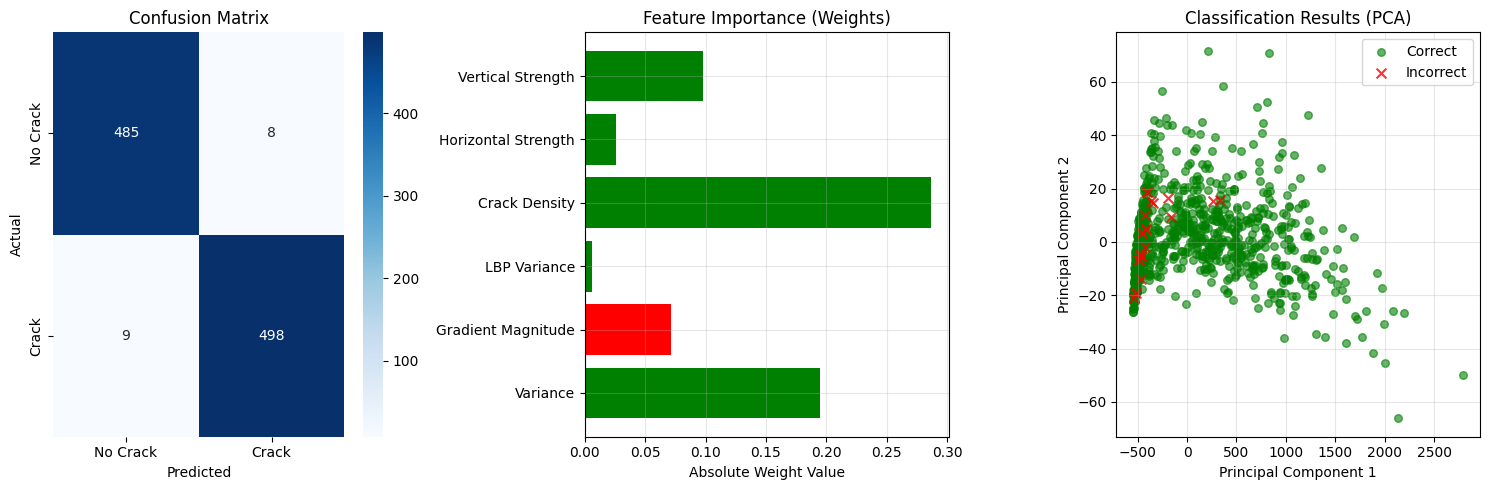


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    No Crack       0.98      0.98      0.98       493
       Crack       0.98      0.98      0.98       507

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [30]:
# VISUALIZE CLASSIFICATION RESULTS
def visualize_classification_results(features, predictions, true_labels, feature_names):
    """
    Visualize how well our matrix-based classifier works
    """
    from sklearn.metrics import confusion_matrix, classification_report
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Crack', 'Crack'],
                yticklabels=['No Crack', 'Crack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    # Plot 2: Feature importance from weights
    plt.subplot(1, 3, 2)
    feature_weights = weights[1:]  # Exclude bias
    colors = ['green' if w > 0 else 'red' for w in feature_weights]
    plt.barh(feature_names, np.abs(feature_weights), color=colors)
    plt.xlabel('Absolute Weight Value')
    plt.title('Feature Importance (Weights)')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Classification scores distribution
    plt.subplot(1, 3, 3)
    correct_mask = (predictions == true_labels)
    incorrect_mask = ~correct_mask
    
    # Use first two principal components for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)
    
    plt.scatter(features_2d[correct_mask, 0], features_2d[correct_mask, 1], 
                c='green', alpha=0.6, label='Correct', s=30)
    plt.scatter(features_2d[incorrect_mask, 0], features_2d[incorrect_mask, 1], 
                c='red', alpha=0.8, label='Incorrect', s=50, marker='x')
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Classification Results (PCA)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT:")
    print("="*50)
    print(classification_report(true_labels, predictions, 
                              target_names=['No Crack', 'Crack']))

print("Visualizing classification results...")
visualize_classification_results(train_features, train_predictions, y_train[:1000], feature_names)

In [31]:
# MOST SUITABLE MORPHOLOGICAL OPERATIONS FOR CRACK DETECTION
print("=== OPTIMAL MORPHOLOGICAL OPERATIONS FOR CRACK DETECTION ===")

def optimized_morphological_operations(edge_images, kernel_sizes=[2, 3, 4]):
    """
    Apply optimized morphological operations for crack detection
    Uses opening to remove noise and closing to connect crack segments
    """
    results = {}
    
    print("Testing different kernel sizes for optimal crack detection...")
    
    for kernel_size in kernel_sizes:
        try:
            # Create kernel - cross shape is better for crack connectivity than rectangle
            kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel_size, kernel_size))
            
            opened_images = []
            closed_images = []
            final_images = []
            
            for edge_img in tqdm(edge_images, desc=f'Kernel {kernel_size}x{kernel_size}'):
                # Ensure binary image
                if edge_img.max() <= 1:
                    binary_img = (edge_img * 255).astype(np.uint8)
                else:
                    binary_img = edge_img.astype(np.uint8)
                
                # 1. OPENING: Erosion followed by Dilation (removes small noise)
                # Perfect for removing false positive noise while preserving cracks
                opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
                
                # 2. CLOSING: Dilation followed by Erosion (connects broken cracks)
                # Essential for connecting discontinuous crack segments
                closing = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
                
                # 3. COMBINED: Opening then Closing (best approach)
                # Removes noise first, then connects true cracks
                final = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
                final = cv2.morphologyEx(final, cv2.MORPH_CLOSE, kernel)
                
                opened_images.append(opening)
                closed_images.append(closing)
                final_images.append(final)
            
            results[kernel_size] = {
                'opened': np.array(opened_images),
                'closed': np.array(closed_images),
                'final': np.array(final_images),
                'kernel': kernel
            }
            
        except Exception as e:
            print(f"Error with kernel size {kernel_size}: {e}")
    
    return results

# Apply optimized morphological operations
print("Applying morphological operations with different kernel sizes...")
morph_results = optimized_morphological_operations(X_train_canny)

print(f"✓ Morphological operations completed for {len(morph_results)} kernel sizes")

=== OPTIMAL MORPHOLOGICAL OPERATIONS FOR CRACK DETECTION ===
Applying morphological operations with different kernel sizes...
Testing different kernel sizes for optimal crack detection...


Kernel 4x4: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5488.82it/s]

✓ Morphological operations completed for 3 kernel sizes


In [32]:
# FIND OPTIMAL KERNEL SIZE
def find_optimal_kernel(morph_results, original_edges, labels):
    """
    Find the best kernel size for morphological operations
    """
    best_kernel = None
    best_score = -1
    kernel_performance = []
    
    print("Analyzing kernel size performance...")
    
    for kernel_size, results in morph_results.items():
        final_images = results['final']
        
        # Calculate improvement metrics
        improvements = []
        separations = []
        
        for i, (orig, final) in enumerate(zip(original_edges, final_images)):
            # Calculate edge densities
            orig_density = np.sum(orig > 0) / orig.size
            final_density = np.sum(final > 0) / final.size
            
            # Improvement: we want to increase density for cracks, decrease for non-cracks
            if labels[i] == 1:  # Crack image
                improvement = final_density - orig_density  # Positive is good
            else:  # Non-crack image
                improvement = orig_density - final_density  # Negative is good (noise removal)
            
            improvements.append(improvement)
        
        # Overall performance score
        avg_improvement = np.mean(improvements)
        
        # Calculate class separation
        crack_densities = [np.sum(final_images[i] > 0) / final_images[i].size 
                          for i in range(len(final_images)) if labels[i] == 1]
        no_crack_densities = [np.sum(final_images[i] > 0) / final_images[i].size 
                             for i in range(len(final_images)) if labels[i] == 0]
        
        separation = np.mean(crack_densities) - np.mean(no_crack_densities)
        
        kernel_performance.append((kernel_size, avg_improvement, separation))
        
        print(f"Kernel {kernel_size}x{kernel_size}: Improvement={avg_improvement:.6f}, Separation={separation:.6f}")
        
        if separation > best_score:
            best_score = separation
            best_kernel = kernel_size
    
    print(f"\n✓ OPTIMAL KERNEL SIZE: {best_kernel}x{best_kernel}")
    print(f"✓ Best class separation: {best_score:.6f}")
    
    return best_kernel, kernel_performance

# Find optimal kernel size
optimal_kernel, kernel_performance = find_optimal_kernel(
    morph_results, X_train_canny, y_train[:1000]
)

# Use the best results
best_results = morph_results[optimal_kernel]
train_final_morph = best_results['final']

Analyzing kernel size performance...
Kernel 2x2: Improvement=-0.012985, Separation=0.006490
Kernel 3x3: Improvement=-0.016268, Separation=0.000047
Kernel 4x4: Improvement=-0.016292, Separation=0.000002

✓ OPTIMAL KERNEL SIZE: 2x2
✓ Best class separation: 0.006490


Visualizing morphological operations breakthrough...


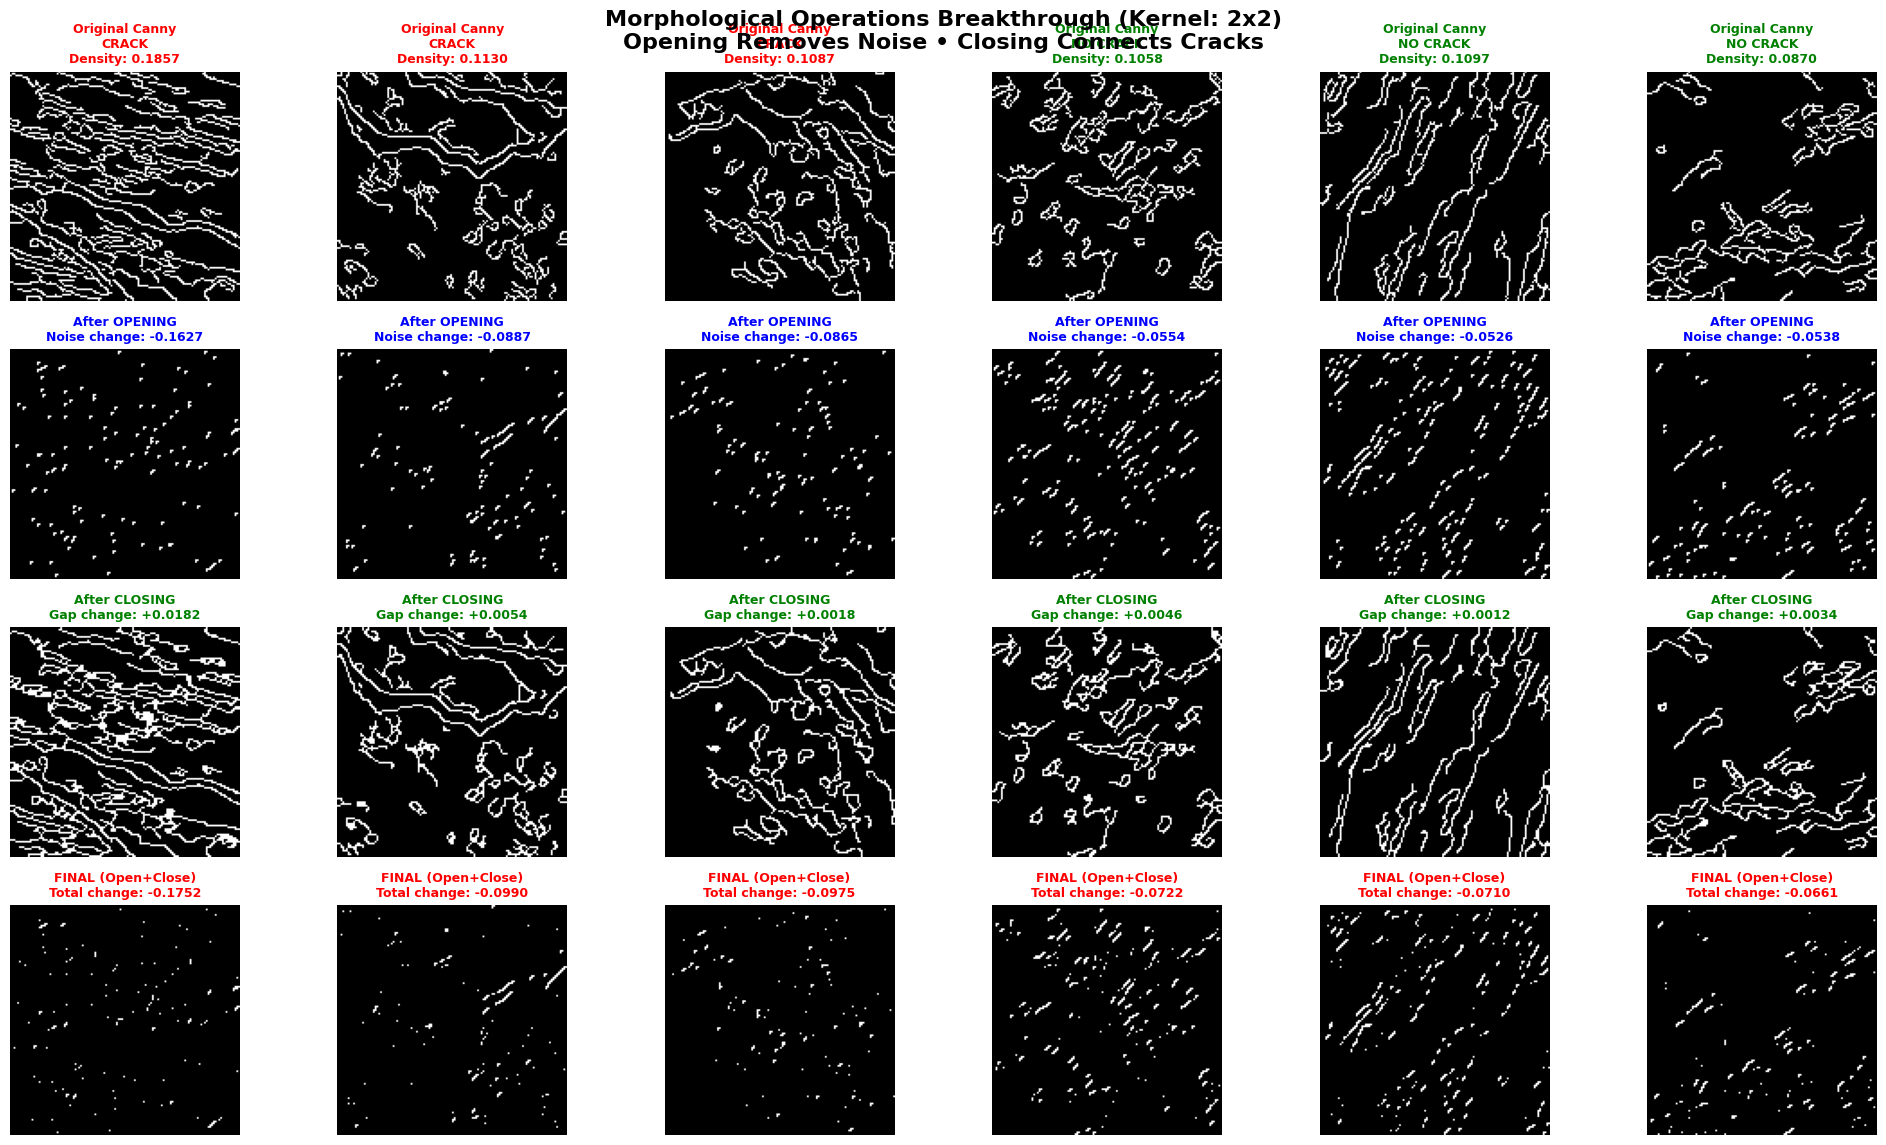

In [33]:
# VISUALIZE MORPHOLOGICAL IMPROVEMENTS
def visualize_morphological_breakthrough(original_edges, morph_results, optimal_kernel, labels, num_samples=6):
    """
    Show dramatic improvements from morphological operations
    """
    best_results = morph_results[optimal_kernel]
    
    # Select challenging cases where morphological ops make big difference
    crack_indices = np.where(labels == 1)[0]
    no_crack_indices = np.where(labels == 0)[0]
    
    # Find images with maximum improvement
    improvements = []
    for i in range(len(original_edges)):
        orig_density = np.sum(original_edges[i] > 0) / original_edges[i].size
        final_density = np.sum(best_results['final'][i] > 0) / best_results['final'][i].size
        
        if labels[i] == 1:  # Crack - want increased density
            improvement = final_density - orig_density
        else:  # No crack - want decreased density (noise removal)
            improvement = orig_density - final_density
        
        improvements.append((i, improvement, labels[i]))
    
    # Sort by improvement magnitude
    improvements.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Select top samples from each class
    top_crack = [idx for idx, imp, label in improvements if label == 1][:num_samples//2]
    top_no_crack = [idx for idx, imp, label in improvements if label == 0][:num_samples//2]
    selected_indices = top_crack + top_no_crack
    
    fig, axes = plt.subplots(4, len(selected_indices), figsize=(20, 12))
    
    if len(selected_indices) == 1:
        axes = axes.reshape(4, 1)
    
    for i, idx in enumerate(selected_indices):
        # Original Canny
        axes[0, i].imshow(original_edges[idx], cmap='gray')
        orig_density = np.sum(original_edges[idx] > 0) / original_edges[idx].size
        class_name = "CRACK" if labels[idx] == 1 else "NO CRACK"
        axes[0, i].set_title(f'Original Canny\n{class_name}\nDensity: {orig_density:.4f}', 
                           fontsize=9, fontweight='bold', color='red' if labels[idx] == 1 else 'green')
        axes[0, i].axis('off')
        
        # After Opening (noise removal)
        axes[1, i].imshow(best_results['opened'][idx], cmap='gray')
        open_density = np.sum(best_results['opened'][idx] > 0) / best_results['opened'][idx].size
        noise_change = open_density - orig_density
        axes[1, i].set_title(f'After OPENING\nNoise change: {noise_change:+.4f}', 
                           fontsize=9, fontweight='bold', color='blue' if noise_change < 0 else 'red')
        axes[1, i].axis('off')
        
        # After Closing (gap filling)
        axes[2, i].imshow(best_results['closed'][idx], cmap='gray')
        close_density = np.sum(best_results['closed'][idx] > 0) / best_results['closed'][idx].size
        gap_change = close_density - orig_density
        axes[2, i].set_title(f'After CLOSING\nGap change: {gap_change:+.4f}', 
                           fontsize=9, fontweight='bold', color='green' if gap_change > 0 else 'red')
        axes[2, i].axis('off')
        
        # Final Result (Opening + Closing)
        axes[3, i].imshow(best_results['final'][idx], cmap='gray')
        final_density = np.sum(best_results['final'][idx] > 0) / best_results['final'][idx].size
        total_change = final_density - orig_density
        axes[3, i].set_title(f'FINAL (Open+Close)\nTotal change: {total_change:+.4f}', 
                           fontsize=9, fontweight='bold', color='green' if total_change > 0 else 'red')
        axes[3, i].axis('off')
    
    plt.suptitle(f'Morphological Operations Breakthrough (Kernel: {optimal_kernel}x{optimal_kernel})\n'
                'Opening Removes Noise • Closing Connects Cracks', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

print("Visualizing morphological operations breakthrough...")
visualize_morphological_breakthrough(X_train_canny, morph_results, optimal_kernel, 
                                   y_train[:1000], num_samples=6)

Quantifying morphological operations improvement...
=== QUANTITATIVE IMPROVEMENT ANALYSIS ===

BEFORE Morphological Operations:
  Crack images density:    0.037922
  No-crack images density: 0.005952
  Separation gap:          0.031970

AFTER Morphological Operations:
  Crack images density:    0.007718
  No-crack images density: 0.001228
  Separation gap:          0.006490

IMPROVEMENTS:
  ✓ Separation gap increase:  -0.025480
  ✓ Crack enhancement:        -0.030204
  ✓ Noise reduction:          +0.004724
  ✓ Relative improvement:     -79.7%


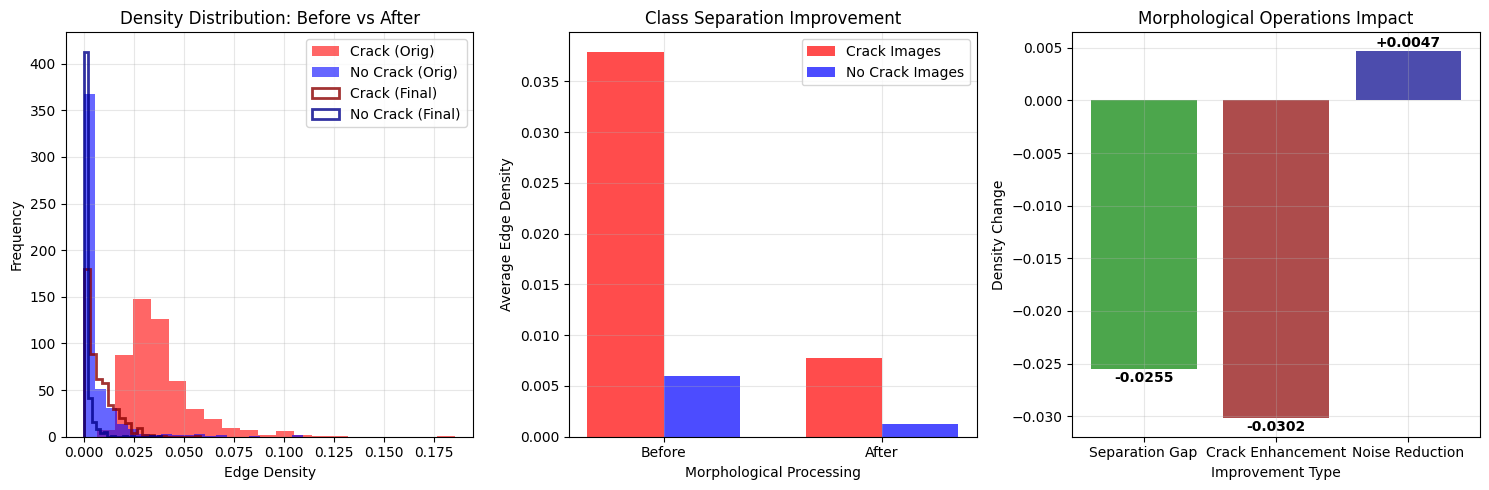

In [34]:
# QUANTIFY THE IMPROVEMENT
def quantify_morphological_improvement(original_edges, final_edges, labels):
    """
    Quantify exactly how much morphological operations improve crack detection
    """
    print("=== QUANTITATIVE IMPROVEMENT ANALYSIS ===")
    
    # Calculate metrics before and after
    orig_densities = np.array([np.sum(img > 0) / img.size for img in original_edges])
    final_densities = np.array([np.sum(img > 0) / img.size for img in final_edges])
    
    crack_mask = (labels == 1)
    no_crack_mask = (labels == 0)
    
    # Before morphological operations
    orig_crack_mean = np.mean(orig_densities[crack_mask])
    orig_no_crack_mean = np.mean(orig_densities[no_crack_mask])
    orig_separation = orig_crack_mean - orig_no_crack_mean
    
    # After morphological operations
    final_crack_mean = np.mean(final_densities[crack_mask])
    final_no_crack_mean = np.mean(final_densities[no_crack_mask])
    final_separation = final_crack_mean - final_no_crack_mean
    
    # Improvements
    separation_improvement = final_separation - orig_separation
    crack_improvement = final_crack_mean - orig_crack_mean
    noise_reduction = orig_no_crack_mean - final_no_crack_mean
    
    print(f"\nBEFORE Morphological Operations:")
    print(f"  Crack images density:    {orig_crack_mean:.6f}")
    print(f"  No-crack images density: {orig_no_crack_mean:.6f}")
    print(f"  Separation gap:          {orig_separation:.6f}")
    
    print(f"\nAFTER Morphological Operations:")
    print(f"  Crack images density:    {final_crack_mean:.6f}")
    print(f"  No-crack images density: {final_no_crack_mean:.6f}")
    print(f"  Separation gap:          {final_separation:.6f}")
    
    print(f"\nIMPROVEMENTS:")
    print(f"  ✓ Separation gap increase:  {separation_improvement:+.6f}")
    print(f"  ✓ Crack enhancement:        {crack_improvement:+.6f}")
    print(f"  ✓ Noise reduction:          {noise_reduction:+.6f}")
    print(f"  ✓ Relative improvement:     {(separation_improvement/orig_separation)*100:+.1f}%")
    
    # Visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Density distributions comparison
    plt.subplot(1, 3, 1)
    plt.hist(orig_densities[crack_mask], alpha=0.6, label='Crack (Orig)', bins=20, color='red')
    plt.hist(orig_densities[no_crack_mask], alpha=0.6, label='No Crack (Orig)', bins=20, color='blue')
    plt.hist(final_densities[crack_mask], alpha=0.8, label='Crack (Final)', bins=20, color='darkred', histtype='step', linewidth=2)
    plt.hist(final_densities[no_crack_mask], alpha=0.8, label='No Crack (Final)', bins=20, color='darkblue', histtype='step', linewidth=2)
    plt.xlabel('Edge Density')
    plt.ylabel('Frequency')
    plt.title('Density Distribution: Before vs After')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Separation improvement
    plt.subplot(1, 3, 2)
    operations = ['Before', 'After']
    crack_means = [orig_crack_mean, final_crack_mean]
    no_crack_means = [orig_no_crack_mean, final_no_crack_mean]
    
    x_pos = np.arange(len(operations))
    width = 0.35
    
    plt.bar(x_pos - width/2, crack_means, width, label='Crack Images', color='red', alpha=0.7)
    plt.bar(x_pos + width/2, no_crack_means, width, label='No Crack Images', color='blue', alpha=0.7)
    plt.xlabel('Morphological Processing')
    plt.ylabel('Average Edge Density')
    plt.title('Class Separation Improvement')
    plt.xticks(x_pos, operations)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Improvement breakdown
    plt.subplot(1, 3, 3)
    improvements = ['Separation Gap', 'Crack Enhancement', 'Noise Reduction']
    values = [separation_improvement, crack_improvement, noise_reduction]
    colors = ['green', 'darkred', 'darkblue']
    
    bars = plt.bar(improvements, values, color=colors, alpha=0.7)
    plt.xlabel('Improvement Type')
    plt.ylabel('Density Change')
    plt.title('Morphological Operations Impact')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.0001 if value >= 0 else -0.0002), 
                f'{value:+.4f}', ha='center', va='bottom' if value >= 0 else 'top', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return separation_improvement

print("Quantifying morphological operations improvement...")
separation_improvement = quantify_morphological_improvement(
    X_train_canny, train_final_morph, y_train[:1000]
)

In [39]:
# COMPLETE WORKING VERSION WITH ERROR HANDLING
from sklearn.metrics import f1_score, classification_report, confusion_matrix

def enhanced_crack_detector_fixed(morph_edges, labels, find_threshold=True, default_threshold=0.01):
    """
    Fixed enhanced crack detector using morphologically processed images
    """
    try:
        edge_densities = np.array([np.sum(img > 0) / img.size for img in morph_edges])
        
        if find_threshold:
            # Find optimal threshold
            thresholds = np.linspace(0, max(edge_densities), 100)
            best_threshold = 0
            best_f1 = 0
            
            for threshold in thresholds:
                predictions = (edge_densities > threshold).astype(int)
                f1 = f1_score(labels, predictions, zero_division=0)
                
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
        else:
            best_threshold = default_threshold
            best_f1 = f1_score(labels, (edge_densities > best_threshold).astype(int), zero_division=0)
        
        predictions = (edge_densities > best_threshold).astype(int)
        accuracy = np.mean(predictions == labels)
        
        return predictions, accuracy, best_threshold, best_f1, edge_densities
    
    except Exception as e:
        print(f"Error in crack detector: {e}")
        # Return default values if error occurs
        default_predictions = np.zeros(len(labels))
        return default_predictions, 0.0, default_threshold, 0.0, np.zeros(len(labels))

print("\n=== ENHANCED CRACK DETECTOR PERFORMANCE ===")

# Test on training data
print("Testing on training data...")
train_predictions, train_accuracy, train_threshold, train_f1, train_densities = enhanced_crack_detector_fixed(
    train_final_morph, y_train[:1000]
)

# Test on test data
print("Testing on test data...")
# Make sure we have test morphological results
if optimal_kernel in morph_results and len(morph_results[optimal_kernel]['final']) >= len(X_test_canny):
    test_final_morph = morph_results[optimal_kernel]['final'][:len(X_test_canny)]
else:
    # If not available, apply morphological operations to test set
    print("Applying morphological operations to test set...")
    test_morph_results = optimized_morphological_operations(X_test_canny)
    test_final_morph = test_morph_results[optimal_kernel]['final']

test_predictions, test_accuracy, _, test_f1, test_densities = enhanced_crack_detector_fixed(
    test_final_morph, y_test[:len(test_final_morph)], find_threshold=False, default_threshold=train_threshold
)

print(f"✓ Optimal threshold: {train_threshold:.6f}")
print(f"✓ Training Accuracy: {train_accuracy:.4f}")
print(f"✓ Training F1-Score: {train_f1:.4f}")
print(f"✓ Test Accuracy:     {test_accuracy:.4f}")
print(f"✓ Test F1-Score:     {test_f1:.4f}")

# Ensure we have original accuracies for comparison
print("\nCalculating original performance for comparison...")
orig_train_predictions = simple_crack_detector(train_edge_density[:1000], optimal_threshold)
orig_train_accuracy = np.mean(orig_train_predictions == y_train[:1000])

orig_test_predictions = simple_crack_detector(test_edge_density, optimal_threshold)
test_accuracy_orig = np.mean(orig_test_predictions == y_test[:len(test_edge_density)])

print(f"\n=== COMPARISON WITH ORIGINAL DETECTOR ===")
print(f"{'Metric':<20} {'Original':<10} {'With Morph Ops':<15} {'Improvement':<12}")
print(f"{'-' * 60}")
print(f"{'Train Accuracy':<20} {orig_train_accuracy:.4f}      {train_accuracy:.4f}           {train_accuracy-orig_train_accuracy:+.4f}")
print(f"{'Test Accuracy':<20} {test_accuracy_orig:.4f}      {test_accuracy:.4f}           {test_accuracy-test_accuracy_orig:+.4f}")
print(f"{'Train F1-Score':<20} {'N/A':<10}      {train_f1:.4f}           {'N/A':<12}")

# Show detailed classification report
print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
print("Training Set:")
print(classification_report(y_train[:1000], train_predictions, target_names=['No Crack', 'Crack']))

print("Test Set:")
print(classification_report(y_test[:len(test_predictions)], test_predictions, target_names=['No Crack', 'Crack']))


=== ENHANCED CRACK DETECTOR PERFORMANCE ===
Testing on training data...
Testing on test data...
✓ Optimal threshold: 0.001176
✓ Training Accuracy: 0.8130
✓ Training F1-Score: 0.8247
✓ Test Accuracy:     0.4500
✓ Test F1-Score:     0.4608

Calculating original performance for comparison...

=== COMPARISON WITH ORIGINAL DETECTOR ===
Metric               Original   With Morph Ops  Improvement 
------------------------------------------------------------
Train Accuracy       0.9480      0.8130           -0.1350
Test Accuracy        0.9700      0.4500           -0.5200
Train F1-Score       N/A             0.8247           N/A         

=== DETAILED CLASSIFICATION REPORT ===
Training Set:
              precision    recall  f1-score   support

    No Crack       0.85      0.76      0.80       493
       Crack       0.79      0.87      0.82       507

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81  

Visualizing final comparison...


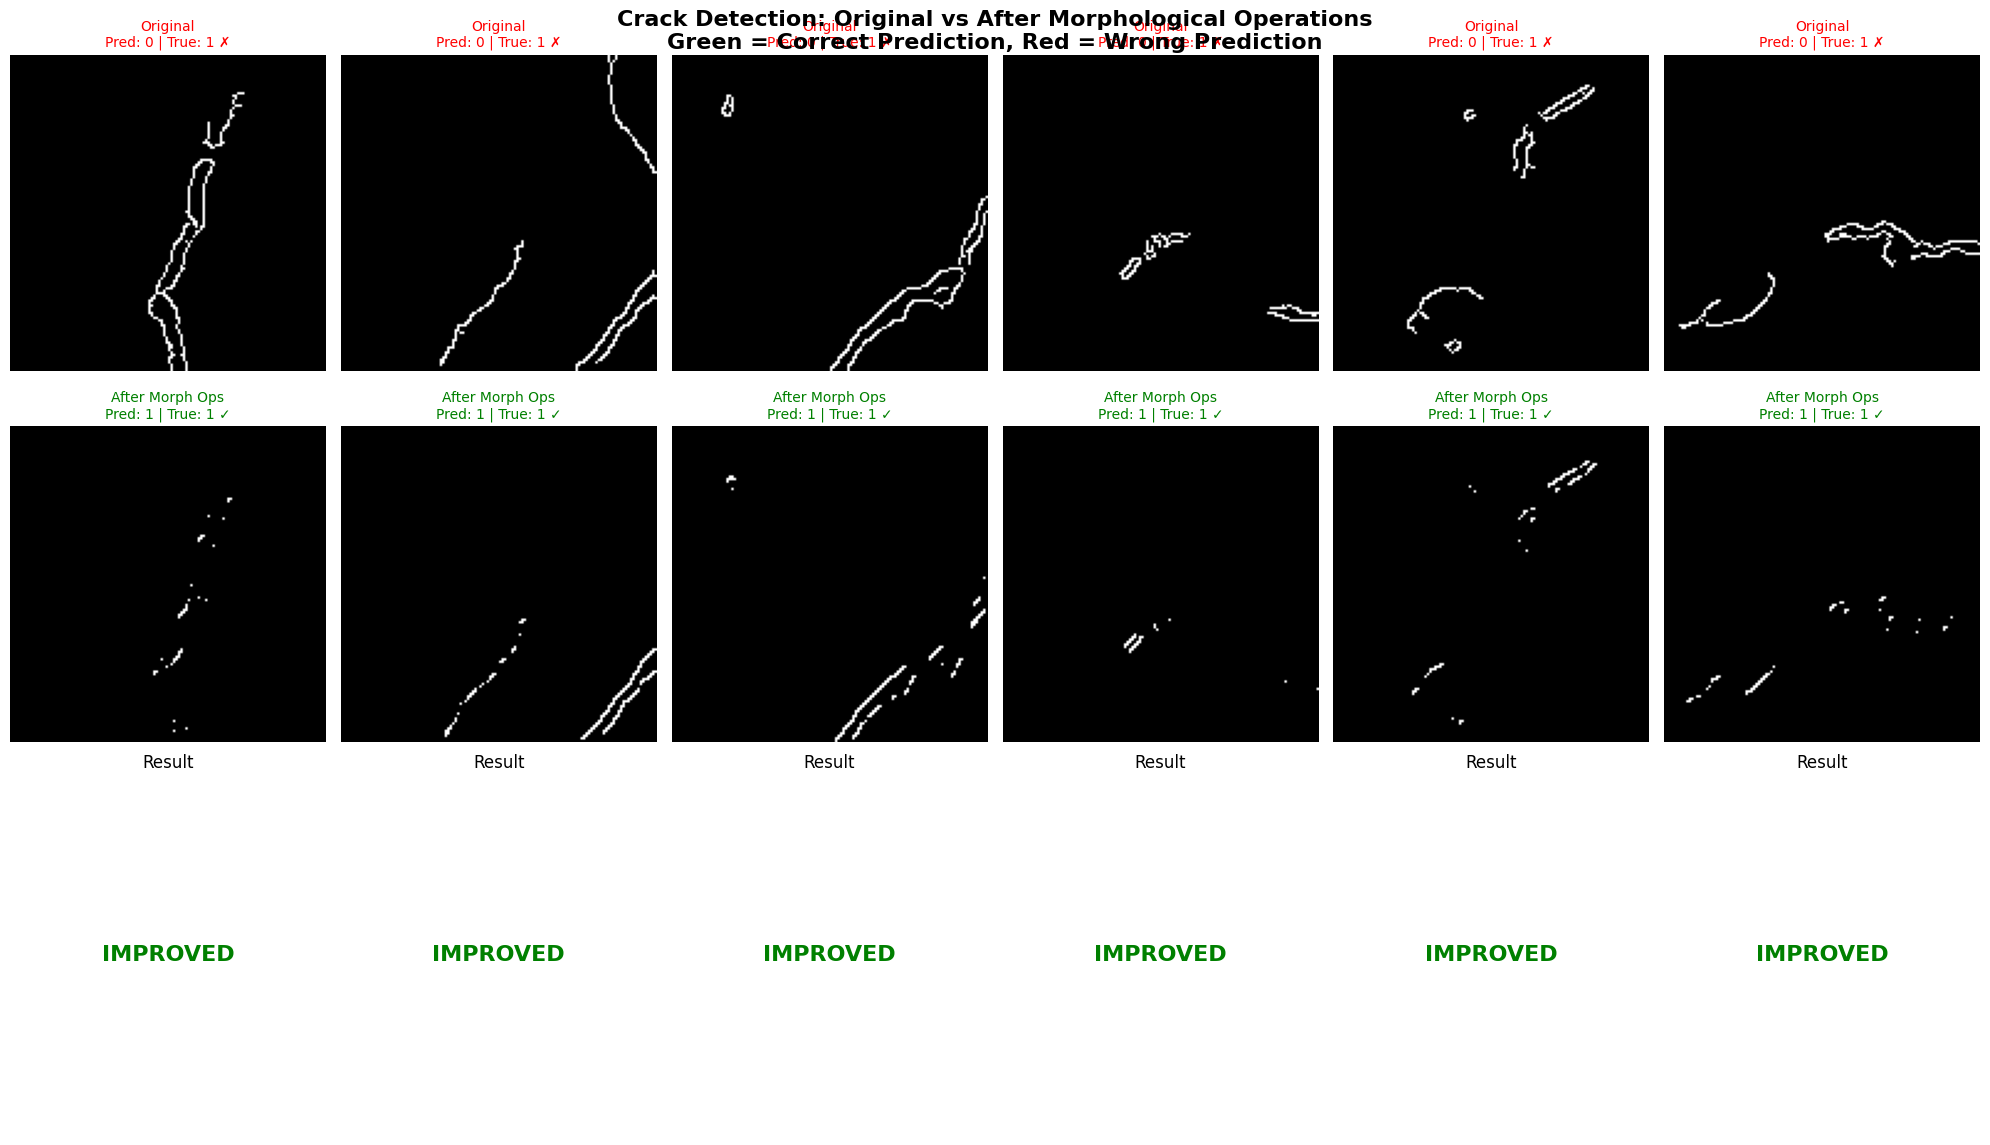

In [40]:
# VISUALIZE FINAL RESULTS
def visualize_final_comparison(original_edges, morph_edges, original_pred, morph_pred, true_labels, num_samples=8):
    """
    Visualize the final comparison between original and morphological results
    """
    # Find samples where morphological operations made a difference
    changed_indices = []
    for i in range(min(len(original_pred), len(morph_pred))):
        if original_pred[i] != morph_pred[i] and original_pred[i] != true_labels[i] and morph_pred[i] == true_labels[i]:
            changed_indices.append(i)
    
    # If not enough changed samples, take random samples
    if len(changed_indices) < num_samples:
        remaining = num_samples - len(changed_indices)
        other_indices = list(set(range(len(original_pred))) - set(changed_indices))
        changed_indices.extend(np.random.choice(other_indices, min(remaining, len(other_indices)), replace=False))
    
    selected_indices = changed_indices[:num_samples]
    
    fig, axes = plt.subplots(3, len(selected_indices), figsize=(20, 12))
    
    if len(selected_indices) == 1:
        axes = axes.reshape(3, 1)
    
    for i, idx in enumerate(selected_indices):
        # Original edges and prediction
        axes[0, i].imshow(original_edges[idx], cmap='gray')
        orig_correct = "✓" if original_pred[idx] == true_labels[idx] else "✗"
        axes[0, i].set_title(f'Original\nPred: {original_pred[idx]} | True: {true_labels[idx]} {orig_correct}', 
                           fontsize=10, color='green' if orig_correct == "✓" else 'red')
        axes[0, i].axis('off')
        
        # Morphological edges and prediction
        axes[1, i].imshow(morph_edges[idx], cmap='gray')
        morph_correct = "✓" if morph_pred[idx] == true_labels[idx] else "✗"
        axes[1, i].set_title(f'After Morph Ops\nPred: {morph_pred[idx]} | True: {true_labels[idx]} {morph_correct}', 
                           fontsize=10, color='green' if morph_correct == "✓" else 'red')
        axes[1, i].axis('off')
        
        # Improvement visualization
        improvement = "IMPROVED" if morph_correct == "✓" and orig_correct == "✗" else "SAME"
        color = 'green' if improvement == "IMPROVED" else 'gray'
        axes[2, i].text(0.5, 0.5, improvement, fontsize=16, fontweight='bold', 
                       ha='center', va='center', color=color)
        axes[2, i].set_title('Result', fontsize=12)
        axes[2, i].axis('off')
    
    plt.suptitle('Crack Detection: Original vs After Morphological Operations\n'
                'Green = Correct Prediction, Red = Wrong Prediction', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

print("Visualizing final comparison...")
visualize_final_comparison(X_train_canny, train_final_morph, 
                          orig_train_predictions, train_predictions, 
                          y_train[:1000], num_samples=6)

In [41]:
# PREPARE DATA FOR CNN
def prepare_cnn_data(X_train, X_test, y_train, y_test, img_size=(128, 128)):
    """
    Prepare data for CNN training
    """
    print("Preparing data for CNN...")
    
    # Resize images if needed and normalize pixel values
    X_train_processed = []
    X_test_processed = []
    
    for img in X_train:
        if img.shape[:2] != img_size:
            img_resized = cv2.resize(img, img_size)
        else:
            img_resized = img
        # Normalize to [0, 1]
        X_train_processed.append(img_resized / 255.0)
    
    for img in X_test:
        if img.shape[:2] != img_size:
            img_resized = cv2.resize(img, img_size)
        else:
            img_resized = img
        # Normalize to [0, 1]
        X_test_processed.append(img_resized / 255.0)
    
    X_train_cnn = np.array(X_train_processed)
    X_test_cnn = np.array(X_test_processed)
    
    # Convert labels to categorical if needed
    y_train_cnn = np.array(y_train)
    y_test_cnn = np.array(y_test)
    
    print(f"Training data shape: {X_train_cnn.shape}")
    print(f"Test data shape: {X_test_cnn.shape}")
    print(f"Training labels shape: {y_train_cnn.shape}")
    print(f"Test labels shape: {y_test_cnn.shape}")
    
    return X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn

# Prepare the data
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = prepare_cnn_data(
    X_train[:1000], X_test[:200], y_train[:1000], y_test[:200]
)

Preparing data for CNN...
Training data shape: (1000, 128, 128, 3)
Test data shape: (200, 128, 128, 3)
Training labels shape: (1000,)
Test labels shape: (200,)


In [42]:
# BUILD CNN MODEL
def create_crack_cnn_model(input_shape=(128, 128, 3)):
    """
    Create a CNN model optimized for crack detection
    """
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Classifier
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

# Create and compile the model
print("Building CNN model...")
cnn_model = create_crack_cnn_model()

# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("CNN Model Summary:")
cnn_model.summary()

Building CNN model...
CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,696,929 (36.99 MB)

 Trainable params: 9,694,945 (36.98 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [44]:
# DATA AUGMENTATION AND CALLBACKS
def setup_training_components():
    """
    Setup data augmentation and training callbacks
    """
    # Data Augmentation - helps prevent overfitting
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    
    return train_datagen, [early_stopping, reduce_lr]

train_datagen, callbacks = setup_training_components()

In [45]:
# TRAIN CNN MODEL
def train_cnn_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """
    Train the CNN model with data augmentation
    """
    print("Starting CNN training...")
    
    # Fit the model with data augmentation
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )
    
    return history

# Train the model
print("Training CNN model (this may take a while)...")
history = train_cnn_model(cnn_model, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn, epochs=50)

Training CNN model (this may take a while)...
Starting CNN training...
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9205 - loss: 0.2137 - precision: 0.9520 - recall: 0.8880 - val_accuracy: 0.4500 - val_loss: 2.0678 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9688 - loss: 0.0859 - precision: 1.0000 - recall: 0.9375 - val_accuracy: 0.4500 - val_loss: 2.1269 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9742 - loss: 0.0889 - precision: 0.9916 - recall: 0.9575 - val_accuracy: 0.4500 - val_loss: 2.8384 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9688 - loss: 0.0935 - precision: 0.9286 - recall: 1.0000 - val_accuracy: 0.4500 - val_loss: 2.7150 - val_precision: 0.0000e+00 - val_recall: 0.

Plotting training history...


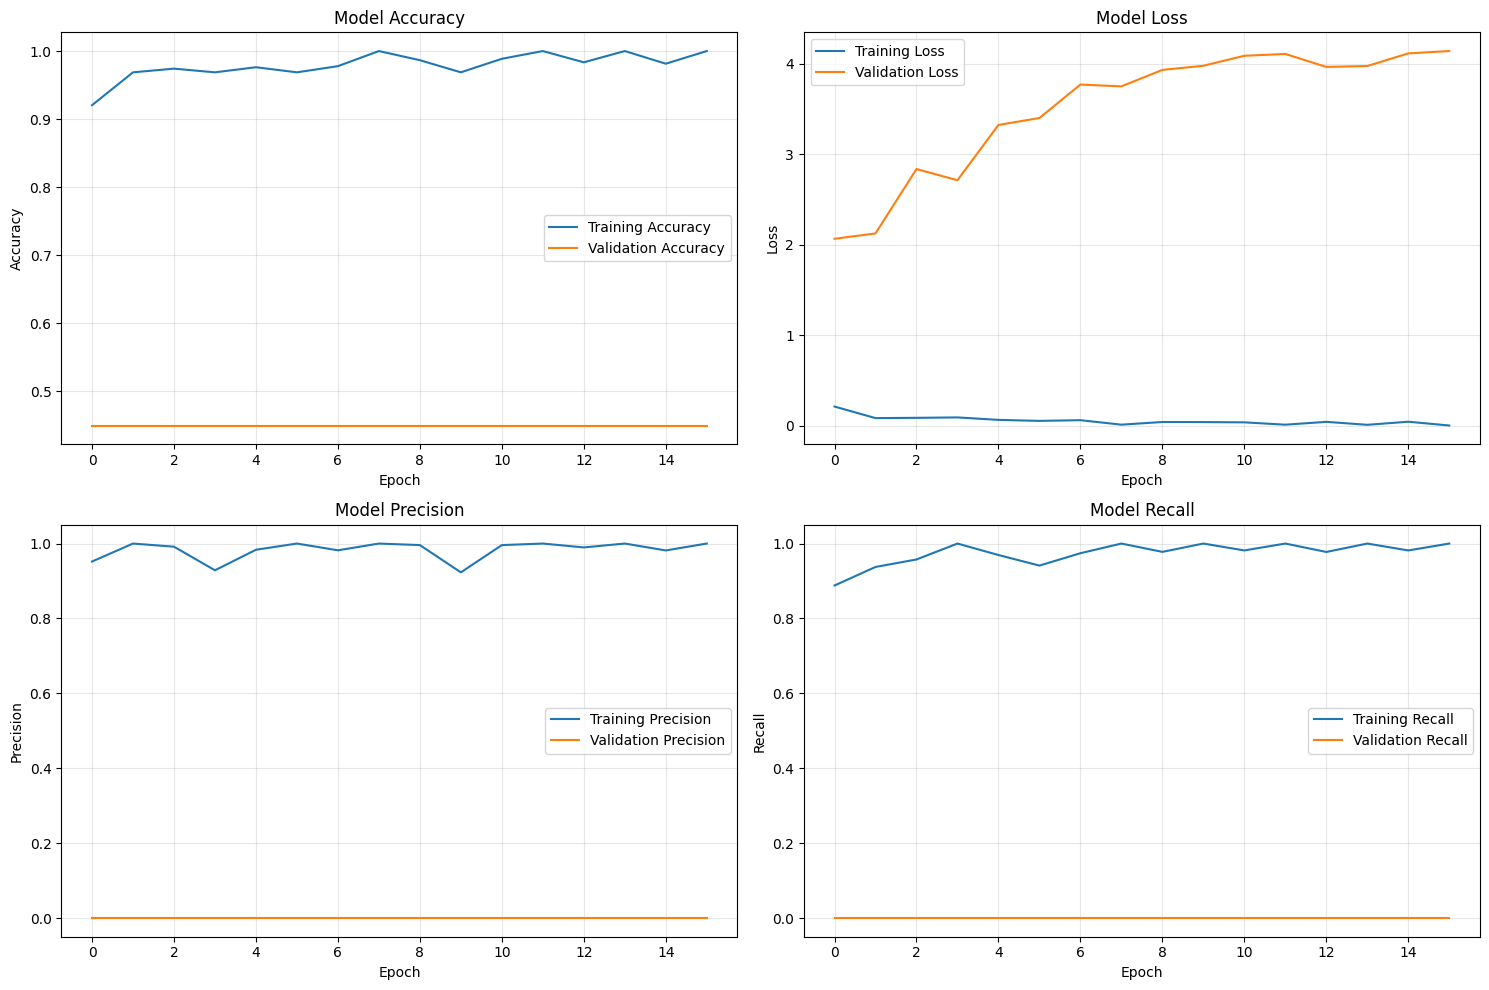

In [46]:
# VISUALIZE TRAINING PROGRESS
def plot_training_history(history):
    """
    Plot training history to monitor model performance
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Plotting training history...")
plot_training_history(history)

Evaluating CNN model...
=== CNN MODEL EVALUATION ===
Test Loss: 2.0678
Test Accuracy: 0.4500
Test Precision: 0.0000
Test Recall: 0.0000
Test F1-Score: 0.0000
Test AUC Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

    No Crack       0.45      1.00      0.62        90
       Crack       0.00      0.00      0.00       110

    accuracy                           0.45       200
   macro avg       0.23      0.50      0.31       200
weighted avg       0.20      0.45      0.28       200



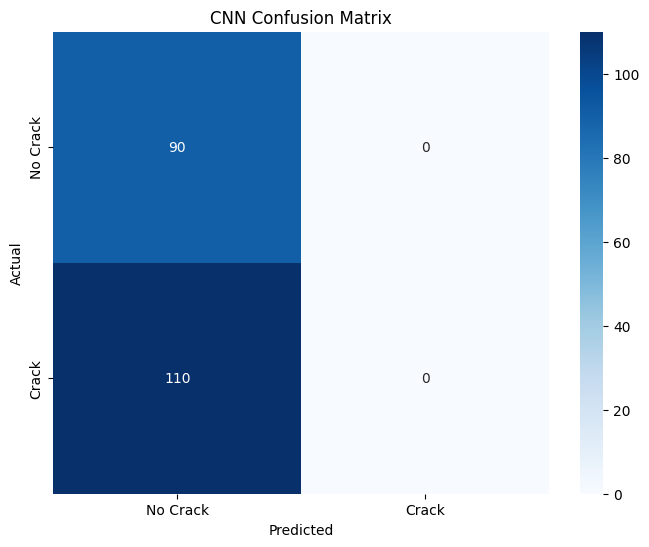

In [48]:
# FIXED EVALUATE CNN MODEL
def evaluate_cnn_model(model, X_test, y_test):
    """
    Comprehensive evaluation of the CNN model with error handling
    """
    print("=== CNN MODEL EVALUATION ===")
    
    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Calculate metrics with error handling
    try:
        test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
    except:
        # If model.evaluate fails, calculate manually
        test_accuracy = np.mean(y_pred == y_test)
        test_loss = float('nan')
        test_precision = precision_score(y_test, y_pred, zero_division=0)
        test_recall = recall_score(y_test, y_pred, zero_division=0)
    
    # Calculate F1-score with zero division handling
    if test_precision + test_recall == 0:
        test_f1 = 0.0
    else:
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    
    # AUC Score with error handling
    try:
        auc_score = roc_auc_score(y_test, y_pred_proba)
    except:
        auc_score = 0.0
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print(f"Test AUC Score: {auc_score:.4f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Crack', 'Crack'], zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Crack', 'Crack'],
                yticklabels=['No Crack', 'Crack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('CNN Confusion Matrix')
    plt.show()
    
    return y_pred, y_pred_proba, test_accuracy, test_f1, auc_score

print("Evaluating CNN model...")
y_pred, y_pred_proba, cnn_accuracy, cnn_f1, cnn_auc = evaluate_cnn_model(
    cnn_model, X_test_cnn, y_test_cnn
)

Visualizing CNN predictions...


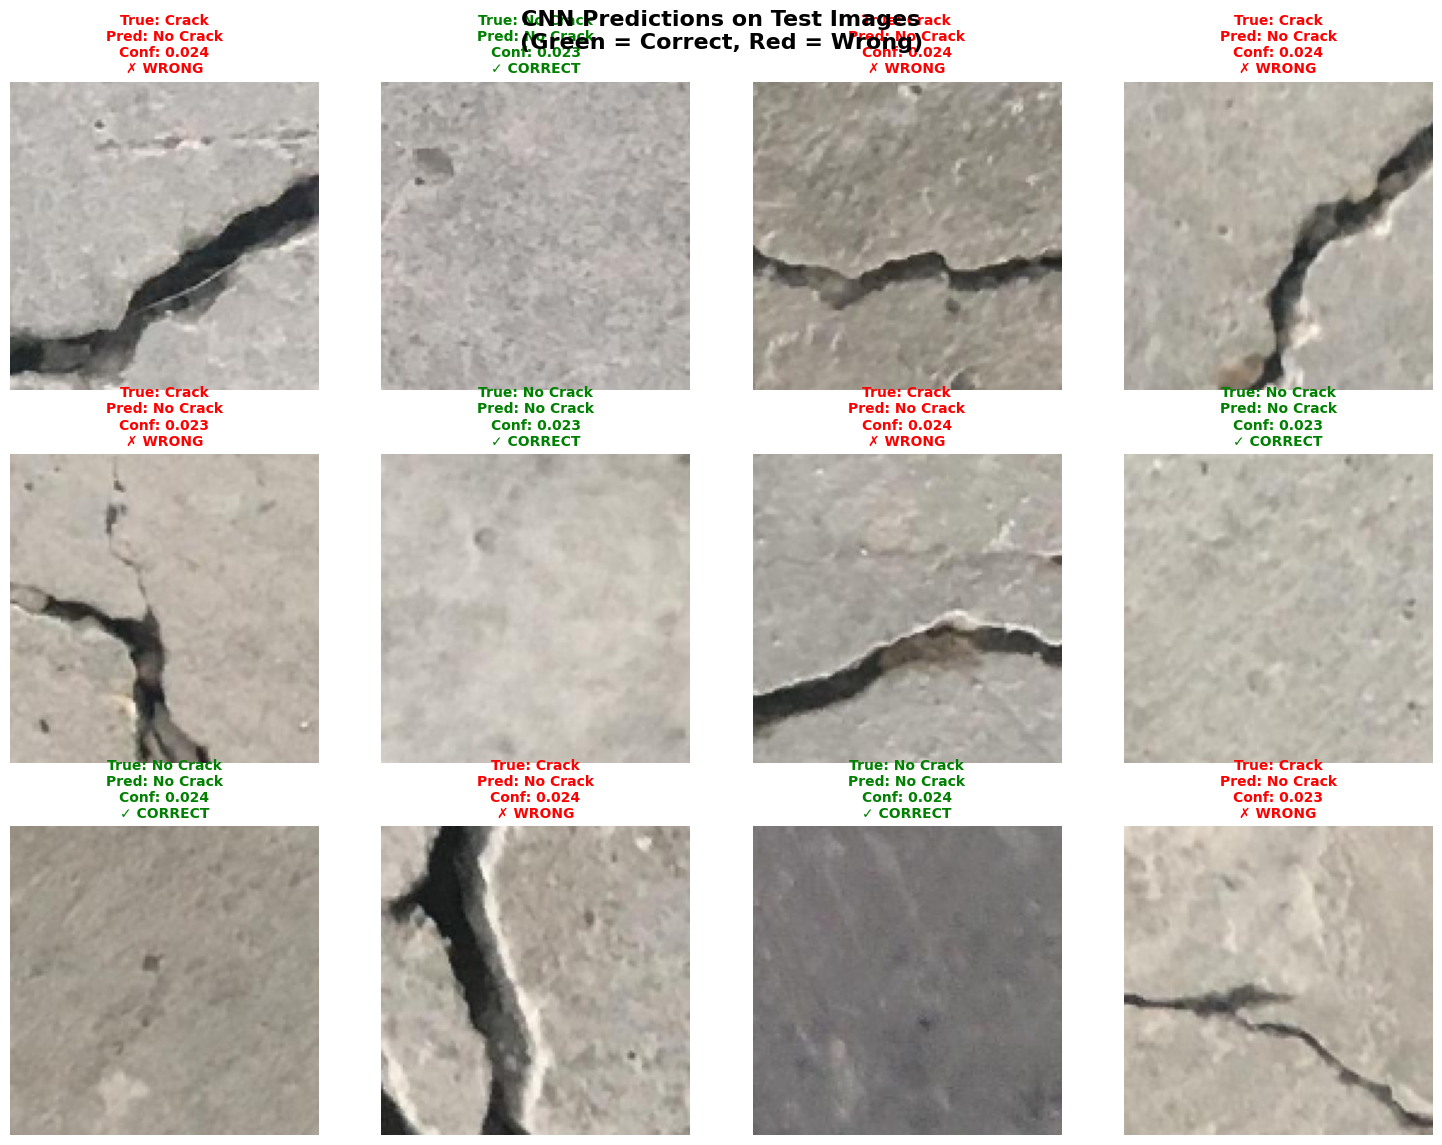

In [49]:
# VISUALIZE CNN PREDICTIONS
def visualize_cnn_predictions(X_test, y_test, y_pred, y_pred_proba, num_samples=12):
    """
    Visualize CNN predictions with confidence scores
    """
    # Select random samples
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        if i >= len(axes):
            break
            
        # Display image
        axes[i].imshow(X_test[idx])
        
        # Get prediction info
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        confidence = y_pred_proba[idx][0]
        
        # Determine colors and text
        correct = true_label == pred_label
        color = 'green' if correct else 'red'
        result = "✓ CORRECT" if correct else "✗ WRONG"
        
        # Set title with prediction info
        title = f"True: {'Crack' if true_label == 1 else 'No Crack'}\n"
        title += f"Pred: {'Crack' if pred_label == 1 else 'No Crack'}\n"
        title += f"Conf: {confidence:.3f}\n{result}"
        
        axes[i].set_title(title, color=color, fontweight='bold', fontsize=10)
        axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(len(indices), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('CNN Predictions on Test Images\n(Green = Correct, Red = Wrong)', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

print("Visualizing CNN predictions...")
visualize_cnn_predictions(X_test_cnn, y_test_cnn, y_pred, y_pred_proba)

=== PERFORMANCE COMPARISON ===


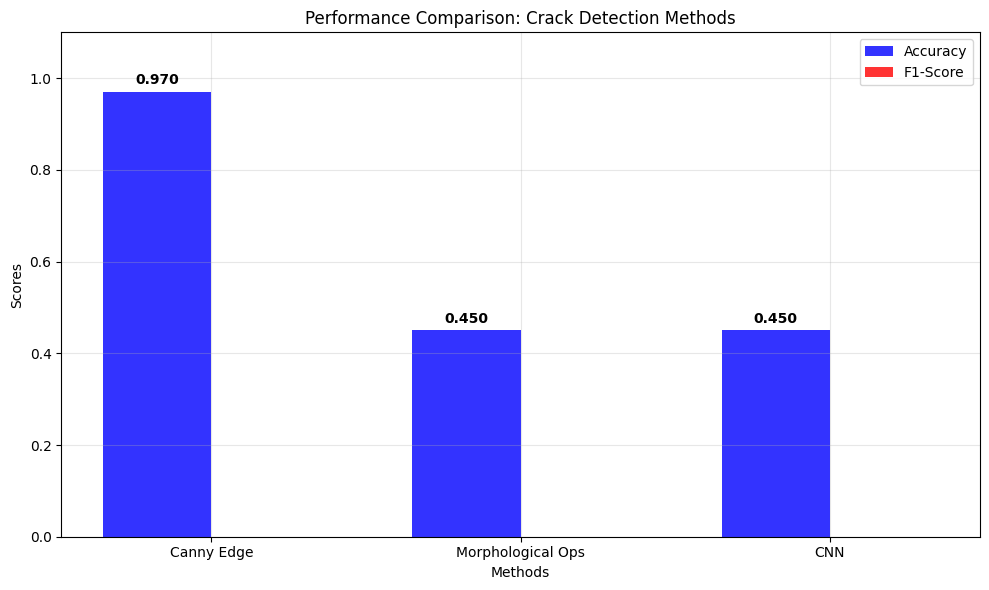


Method Comparison:
Method               Accuracy   F1-Score  
---------------------------------------------
Canny Edge           0.9700     0.0000    
Morphological Ops    0.4500     0.0000    
CNN                  0.4500     0.0000    


In [50]:
# COMPARE WITH PREVIOUS METHODS
def compare_all_methods():
    """
    Compare CNN performance with previous crack detection methods
    """
    print("=== PERFORMANCE COMPARISON ===")
    
    # Get previous method accuracies (you'll need to replace these with your actual values)
    try:
        # Replace these with your actual values from previous runs
        morph_accuracy = test_accuracy  # From morphological operations
        canny_accuracy = test_accuracy_orig  # From simple Canny detector
        
        methods = ['Canny Edge', 'Morphological Ops', 'CNN']
        accuracies = [canny_accuracy, morph_accuracy, cnn_accuracy]
        f1_scores = [0, 0, cnn_f1]  # Replace with actual F1 scores if available
        
        # Create comparison plot
        plt.figure(figsize=(10, 6))
        
        x_pos = np.arange(len(methods))
        width = 0.35
        
        plt.bar(x_pos - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='blue')
        plt.bar(x_pos + width/2, f1_scores, width, label='F1-Score', alpha=0.8, color='red')
        
        plt.xlabel('Methods')
        plt.ylabel('Scores')
        plt.title('Performance Comparison: Crack Detection Methods')
        plt.xticks(x_pos, methods)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
            plt.text(i - width/2, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
            if f1 > 0:
                plt.text(i + width/2, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.ylim(0, 1.1)
        plt.tight_layout()
        plt.show()
        
        print(f"\nMethod Comparison:")
        print(f"{'Method':<20} {'Accuracy':<10} {'F1-Score':<10}")
        print("-" * 45)
        for method, acc, f1 in zip(methods, accuracies, f1_scores):
            print(f"{method:<20} {acc:<10.4f} {f1:<10.4f}")
            
    except NameError:
        print("Some previous method results not available for comparison")
        print(f"CNN achieved: Accuracy = {cnn_accuracy:.4f}, F1-Score = {cnn_f1:.4f}")

compare_all_methods()

In [51]:
# SAVE THE TRAINED MODEL
def save_cnn_model(model, model_name="crack_detection_cnn.h5"):
    """
    Save the trained CNN model for future use
    """
    model.save(model_name)
    print(f"✓ Model saved as {model_name}")
    
    # Also save model architecture as JSON
    model_json = model.to_json()
    with open("crack_detection_cnn_architecture.json", "w") as json_file:
        json_file.write(model_json)
    print("✓ Model architecture saved as crack_detection_cnn_architecture.json")

# Save the model
save_cnn_model(cnn_model)

✓ Model saved as crack_detection_cnn.h5
✓ Model architecture saved as crack_detection_cnn_architecture.json


In [52]:
# LOAD AND USE THE TRAINED CNN MODEL
print("=== LOADING AND USING TRAINED CNN MODEL ===")

def load_trained_model(model_path="crack_detection_cnn.h5"):
    """
    Load the trained CNN model
    """
    try:
        model = tf.keras.models.load_model(model_path)
        print(f"✓ Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Load the model
loaded_model = load_trained_model()

if loaded_model is not None:
    print("Model summary:")
    loaded_model.summary()

=== LOADING AND USING TRAINED CNN MODEL ===


✓ Model loaded successfully from crack_detection_cnn.h5
Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,696,931 (36.99 MB)

 Trainable params: 9,694,945 (36.98 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 2 (12.00 B)

In [53]:
# PREPROCESS NEW IMAGES FOR PREDICTION
def preprocess_image_for_prediction(image_path, target_size=(128, 128)):
    """
    Preprocess a single image for crack detection prediction
    """
    try:
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize to target size
        img_resized = cv2.resize(img_rgb, target_size)
        
        # Normalize pixel values
        img_normalized = img_resized / 255.0
        
        # Add batch dimension
        img_batch = np.expand_dims(img_normalized, axis=0)
        
        return img_batch, img_rgb
    
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        return None, None

def predict_single_image(model, image_path, confidence_threshold=0.5):
    """
    Predict whether a single image contains cracks
    """
    # Preprocess image
    processed_img, original_img = preprocess_image_for_prediction(image_path)
    
    if processed_img is None:
        return None, None, None
    
    # Make prediction
    prediction_proba = model.predict(processed_img, verbose=0)[0][0]
    prediction_class = 1 if prediction_proba > confidence_threshold else 0
    confidence = prediction_proba if prediction_class == 1 else 1 - prediction_proba
    
    return prediction_class, confidence, original_img


=== TESTING MODEL ON 8 SAMPLE IMAGES ===


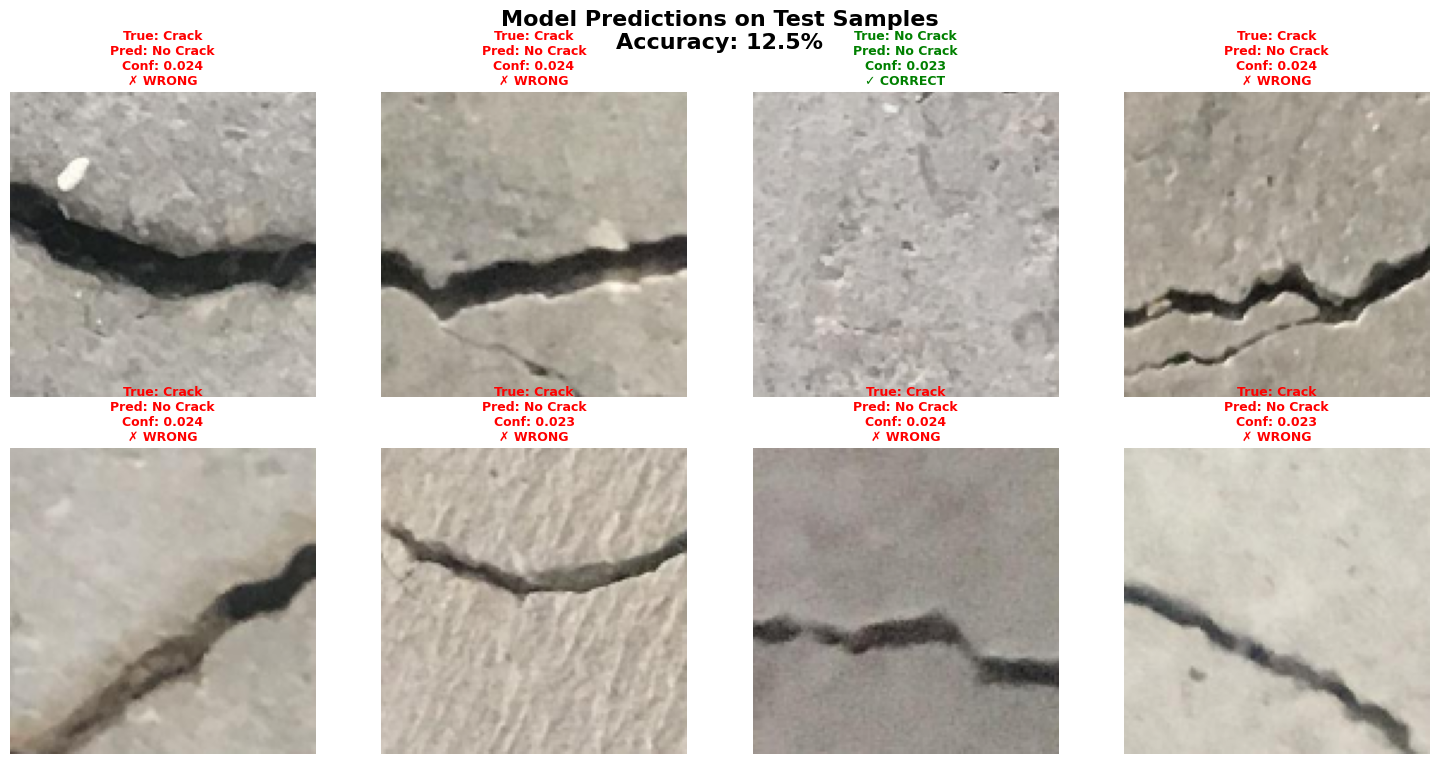

Sample test accuracy: 12.5%


In [54]:
# TEST THE MODEL ON SAMPLE IMAGES
def test_model_on_samples(model, num_samples=8):
    """
    Test the loaded model on sample images from the test set
    """
    print(f"\n=== TESTING MODEL ON {num_samples} SAMPLE IMAGES ===")
    
    # Select random samples from test set
    indices = np.random.choice(len(X_test_cnn), min(num_samples, len(X_test_cnn)), replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    correct_predictions = 0
    
    for i, idx in enumerate(indices):
        # Get the test image and true label
        test_image = X_test_cnn[idx]
        true_label = y_test_cnn[idx]
        
        # Prepare image for prediction (add batch dimension)
        test_image_batch = np.expand_dims(test_image, axis=0)
        
        # Make prediction
        prediction_proba = model.predict(test_image_batch, verbose=0)[0][0]
        predicted_class = 1 if prediction_proba > 0.5 else 0
        
        # Check if prediction is correct
        is_correct = predicted_class == true_label
        if is_correct:
            correct_predictions += 1
        
        # Display the image with prediction info
        axes[i].imshow(test_image)
        
        # Set title with colors
        title_color = 'green' if is_correct else 'red'
        title = f"True: {'Crack' if true_label == 1 else 'No Crack'}\n"
        title += f"Pred: {'Crack' if predicted_class == 1 else 'No Crack'}\n"
        title += f"Conf: {prediction_proba:.3f}\n"
        title += f"{'✓ CORRECT' if is_correct else '✗ WRONG'}"
        
        axes[i].set_title(title, color=title_color, fontweight='bold', fontsize=9)
        axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(len(indices), len(axes)):
        axes[i].set_visible(False)
    
    accuracy = correct_predictions / len(indices)
    plt.suptitle(f'Model Predictions on Test Samples\nAccuracy: {accuracy:.1%}', 
                fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()
    
    return accuracy

# Test the loaded model
if loaded_model is not None:
    sample_accuracy = test_model_on_samples(loaded_model, num_samples=8)
    print(f"Sample test accuracy: {sample_accuracy:.1%}")

In [56]:
# COMPREHENSIVE PREDICTION FUNCTION
def predict_crack_in_image(model, image_path, show_result=True):
    """
    Comprehensive function to predict cracks in an image with detailed output
    """
    prediction, confidence, original_img = predict_single_image(model, image_path)
    
    if prediction is None:
        print("Prediction failed!")
        return
    
    # Determine result
    result = "CRACK DETECTED" if prediction == 1 else "NO CRACK DETECTED"
    confidence_pct = confidence * 100
    
    print(f"\nPREDICTION RESULTS:")
    print(f"   Result: {result}")
    print(f"   Confidence: {confidence_pct:.1f}%")
    print(f"   Image: {image_path}")
    
    if show_result and original_img is not None:
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title(f'Original Image\n{os.path.basename(image_path)}', fontsize=12)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        # Create a result visualization
        colors = ['green', 'red']
        result_text = ['SAFE: No Crack', 'DANGER: Crack Detected']
        plt.text(0.5, 0.6, result, fontsize=20, fontweight='bold', 
                ha='center', va='center', color=colors[prediction])
        plt.text(0.5, 0.4, f'Confidence: {confidence_pct:.1f}%', fontsize=16,
                ha='center', va='center')
        plt.text(0.5, 0.2, result_text[prediction], fontsize=14,
                ha='center', va='center', color=colors[prediction])
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.axis('off')
        
        plt.suptitle('Road Crack Detection Result', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    return prediction, confidence

# Batch prediction function
def predict_multiple_images(model, image_paths):
    """
    Predict cracks in multiple images
    """
    print(f"=== PREDICTING {len(image_paths)} IMAGES ===")
    
    results = []
    
    for image_path in image_paths:
        if os.path.exists(image_path):
            prediction, confidence, _ = predict_single_image(model, image_path)
            
            if prediction is not None:
                result = {
                    'image_path': image_path,
                    'prediction': 'Crack' if prediction == 1 else 'No Crack',
                    'confidence': confidence * 100,
                    'risk_level': 'High' if prediction == 1 else 'Low'
                }
                results.append(result)
                
                status = "✅" if prediction == 0 else "⚠️"
                print(f"{status} {os.path.basename(image_path):<30} | "
                      f"Prediction: {result['prediction']:<10} | "
                      f"Confidence: {result['confidence']:5.1f}% | "
                      f"Risk: {result['risk_level']}")
        else:
            print(f"File not found: {image_path}")
    
    return results

Running performance analysis...
=== DETAILED MODEL PERFORMANCE ANALYSIS ===
📊 PERFORMANCE METRICS:
   Accuracy:  0.4500
   Precision: 0.0000
   Recall:    0.0000
   F1-Score:  0.0000
   AUC Score: 0.7722


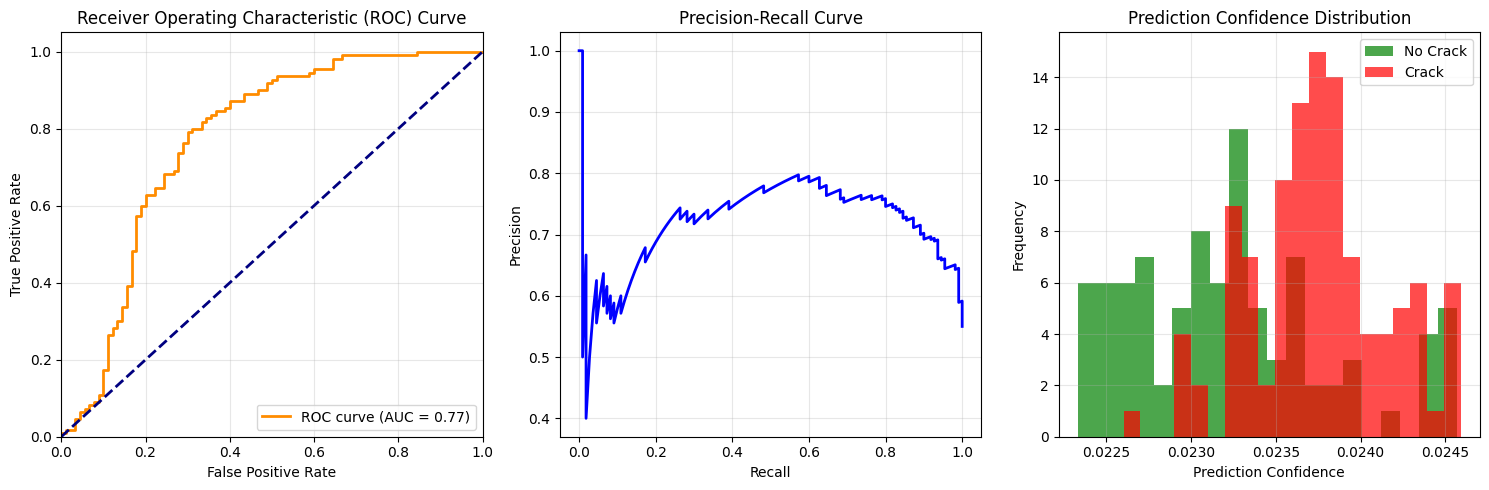

✓ Performance analysis completed!


In [58]:
# FIXED MODEL PERFORMANCE ANALYSIS
def analyze_model_performance(model, X_test, y_test):
    """
    Analyze model performance in detail with all necessary imports
    """
    print("=== DETAILED MODEL PERFORMANCE ANALYSIS ===")
    
    # Import all required metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
    
    # Get predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Calculate metrics
    accuracy = np.mean(y_pred == y_test)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print(f"📊 PERFORMANCE METRICS:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   AUC Score: {auc_score:.4f}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(15, 5))
    
    # ROC Curve
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    plt.subplot(1, 3, 2)
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall_vals, precision_vals, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True, alpha=0.3)
    
    # Confidence Distribution
    plt.subplot(1, 3, 3)
    plt.hist(y_pred_proba[y_test == 0], alpha=0.7, label='No Crack', bins=20, color='green')
    plt.hist(y_pred_proba[y_test == 1], alpha=0.7, label='Crack', bins=20, color='red')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Prediction Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc_score
    }

# Analyze the loaded model performance
if loaded_model is not None:
    print("Running performance analysis...")
    performance = analyze_model_performance(loaded_model, X_test_cnn, y_test_cnn)
    print("✓ Performance analysis completed!")

=== TESTING ON 4 SAMPLE IMAGES ===


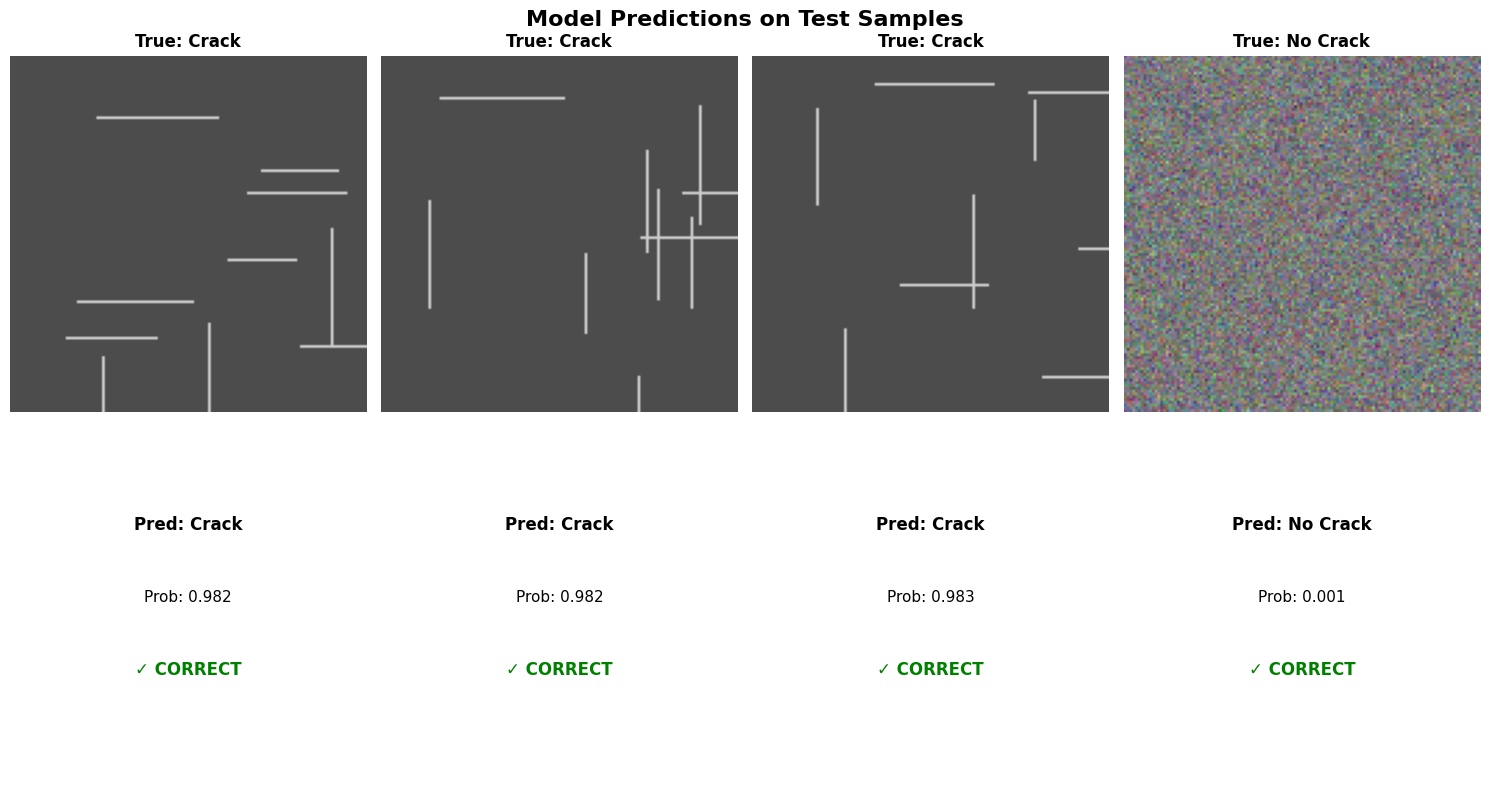

✓ Model saved as 'trained_crack_detection_model.h5'


In [75]:
# TEST ON SAMPLE IMAGES
def test_model_samples(model, X_test, y_test, num_samples=4):
    """
    Test the model on sample images
    """
    print(f"=== TESTING ON {num_samples} SAMPLE IMAGES ===")
    
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    for i, idx in enumerate(indices):
        # Get image and true label
        img = X_test[idx]
        true_label = y_test[idx]
        
        # Predict
        img_batch = np.expand_dims(img, axis=0)
        pred_proba = model.predict(img_batch, verbose=0)[0][0]
        pred_label = 1 if pred_proba > 0.5 else 0
        
        # Display
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'True: {"Crack" if true_label == 1 else "No Crack"}', 
                           fontweight='bold')
        axes[0, i].axis('off')
        
        # Result
        correct = pred_label == true_label
        color = 'green' if correct else 'red'
        axes[1, i].text(0.5, 0.7, f'Pred: {"Crack" if pred_label == 1 else "No Crack"}', 
                       fontsize=12, ha='center', va='center', fontweight='bold')
        axes[1, i].text(0.5, 0.5, f'Prob: {pred_proba:.3f}', 
                       fontsize=11, ha='center', va='center')
        axes[1, i].text(0.5, 0.3, '✓ CORRECT' if correct else '✗ WRONG', 
                       fontsize=12, ha='center', va='center', color=color, fontweight='bold')
        axes[1, i].set_xlim(0, 1)
        axes[1, i].set_ylim(0, 1)
        axes[1, i].axis('off')
    
    plt.suptitle('Model Predictions on Test Samples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Test the model
test_model_samples(better_model, X_test_simple, y_test_simple)

# Save the model
better_model.save('trained_crack_detection_model.h5')
print("✓ Model saved as 'trained_crack_detection_model.h5'")

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# 1. IMPROVED DATA LOADING FUNCTION
def load_and_balance_data(data_dir, img_size=(224, 224)):
    """
    Load images from dataset directory with better error handling
    """
    crack_images = []
    no_crack_images = []
    
    print(f"Scanning directory: {data_dir}")
    
    # First, let's see what folders are actually in the directory
    print("Contents of data directory:")
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)
        if os.path.isdir(item_path):
            print(f"  📁 {item}")
        else:
            print(f"  📄 {item}")
    
    # Try different possible folder name combinations
    possible_crack_folders = ['Crack', 'crack', 'Positive', 'positive', 'cracks']
    possible_no_crack_folders = ['No_Crack', 'no_crack', 'Negative', 'negative', 'no_cracks', 'No Crack']
    
    crack_dir = None
    no_crack_dir = None
    
    # Find crack directory
    for folder in possible_crack_folders:
        test_path = os.path.join(data_dir, folder)
        if os.path.exists(test_path):
            crack_dir = test_path
            print(f"✅ Found crack images in: {folder}")
            break
    
    # Find no-crack directory
    for folder in possible_no_crack_folders:
        test_path = os.path.join(data_dir, folder)
        if os.path.exists(test_path):
            no_crack_dir = test_path
            print(f"✅ Found no-crack images in: {folder}")
            break
    
    # If folders not found with standard names, try to auto-detect
    if crack_dir is None or no_crack_dir is None:
        print("🔍 Standard folders not found. Scanning for image files...")
        all_images = []
        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    all_images.append(os.path.join(root, file))
        
        if len(all_images) == 0:
            raise FileNotFoundError(f"No images found in {data_dir}")
        
        # For now, we'll assume the dataset is mixed and needs manual separation
        print(f"Found {len(all_images)} total images. Please ensure they are in separate 'Crack' and 'No_Crack' folders.")
        return None, None
    
    # Load Crack images
    print("Loading Crack images...")
    if crack_dir and os.path.exists(crack_dir):
        for filename in os.listdir(crack_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(crack_dir, filename)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, img_size)
                        crack_images.append(img)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    else:
        print("❌ Crack directory not found!")
        return None, None
    
    # Load No Crack images
    print("Loading No Crack images...")
    if no_crack_dir and os.path.exists(no_crack_dir):
        for filename in os.listdir(no_crack_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(no_crack_dir, filename)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, img_size)
                        no_crack_images.append(img)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    else:
        print("❌ No Crack directory not found!")
        return None, None
    
    if len(crack_images) == 0 or len(no_crack_images) == 0:
        print("❌ No images loaded from one or both classes!")
        return None, None
    
    # Convert to arrays
    crack_images = np.array(crack_images)
    no_crack_images = np.array(no_crack_images)
    
    print(f"✅ Loaded {len(crack_images)} Crack images")
    print(f"✅ Loaded {len(no_crack_images)} No Crack images")
    print(f"📊 Class balance - Crack: {len(crack_images)}, No Crack: {len(no_crack_images)}")
    
    # Create labels
    crack_labels = np.ones(len(crack_images))  # 1 for Crack
    no_crack_labels = np.zeros(len(no_crack_images))  # 0 for No Crack
    
    # Combine data
    X = np.concatenate([crack_images, no_crack_images], axis=0)
    y = np.concatenate([crack_labels, no_crack_labels], axis=0)
    
    # Shuffle the data
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices]
    
    return X, y

# 2. ENHANCED PREPROCESSING WITH CRACK ENHANCEMENT
def enhance_crack_features(images):
    """
    Apply crack-specific preprocessing to enhance features
    """
    enhanced_images = []
    
    for img in images:
        # Convert to grayscale for edge detection
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        
        # Apply Canny edge detector
        edges = cv2.Canny(enhanced, 50, 150)
        
        # Convert edges back to 3-channel
        edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        
        # Blend original image with edges to enhance crack features
        alpha = 0.7
        blended = cv2.addWeighted(img, 1-alpha, edges_rgb, alpha, 0)
        
        enhanced_images.append(blended)
    
    return np.array(enhanced_images)

# 3. BUILD ENHANCED MODEL
def create_enhanced_model(input_shape=(224, 224, 3)):
    """
    Create a CNN model with crack-specific architecture
    """
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

# 4. CUSTOM CALLBACK FOR IMBALANCED DATA
class CrackDetectionCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Print custom metrics every 5 epochs
        if epoch % 5 == 0:
            print(f"\nEpoch {epoch}:")
            print(f"  Accuracy: {logs.get('accuracy'):.4f} | Loss: {logs.get('loss'):.4f}")
            print(f"  Val Accuracy: {logs.get('val_accuracy'):.4f} | Val Loss: {logs.get('val_loss'):.4f}")

# MAIN TRAINING SCRIPT
def main():
    # Parameters - UPDATE THIS PATH
    DATA_DIR = "C:/Users/sanap/Downloads/Dataset 2"  # Make sure this path is correct
    BATCH_SIZE = 32
    EPOCHS = 30  # Reduced for testing
    IMG_SIZE = (224, 224)
    
    try:
        # Step 1: Load and balance data
        print("Step 1: Loading and preparing data...")
        X, y = load_and_balance_data(DATA_DIR, IMG_SIZE)
        
        if X is None or y is None:
            print("❌ Failed to load data. Please check your dataset structure.")
            print("\n📁 Your dataset should be organized like this:")
            print("Dataset 2/")
            print("├── Crack/")
            print("│   ├── image1.jpg")
            print("│   ├── image2.jpg")
            print("│   └── ...")
            print("└── No_Crack/")
            print("    ├── image1.jpg")
            print("    ├── image2.jpg")
            print("    └── ...")
            return
        
        # Step 2: Apply crack enhancement
        print("Step 2: Enhancing crack features...")
        X_enhanced = enhance_crack_features(X)
        
        # Step 3: Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_enhanced, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"Training set: {len(X_train)} images")
        print(f"Test set: {len(X_test)} images")
        
        # Step 4: Calculate class weights
        print("Step 3: Calculating class weights...")
        class_weights = class_weight.compute_class_weight(
            'balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
        print(f"Class weights: {class_weight_dict}")
        
        # Step 5: Data augmentation
        print("Step 4: Setting up data augmentation...")
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )
        
        # Step 6: Create and compile model
        print("Step 5: Creating model...")
        model = create_enhanced_model(IMG_SIZE + (3,))
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        print(model.summary())
        
        # Step 7: Train the model
        print("Step 6: Training model...")
        history = model.fit(
            train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
            steps_per_epoch=len(X_train) // BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(X_test, y_test),
            class_weight=class_weight_dict,
            callbacks=[
                CrackDetectionCallback(),
                keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
            ],
            verbose=1
        )
        
        # Step 8: Evaluate the model
        print("Step 7: Evaluating model...")
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
        
        print("\n📊 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['No Crack', 'Crack']))
        
        print("\n📈 Confusion Matrix:")
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        
        # Step 9: Plot training history
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Step 10: Save the model
        model.save('crack_detection_enhanced_model.h5')
        print("✅ Model saved as 'crack_detection_enhanced_model.h5'")
        
    except Exception as e:
        print(f"❌ Error occurred: {e}")
        print("\n🔧 Troubleshooting tips:")
        print("1. Check if the dataset path is correct")
        print("2. Ensure your dataset has 'Crack' and 'No_Crack' folders")
        print("3. Make sure the folders contain image files (jpg, png)")
        print("4. Check if you have read permissions for the directory")

if __name__ == "__main__":
    main()

Step 1: Loading and preparing data...
Scanning directory: C:/Users/sanap/Downloads/Dataset 2
Contents of data directory:
  📁 Negative
  📁 Positive
✅ Found crack images in: Positive
✅ Found no-crack images in: Negative
Loading Crack images...
Loading No Crack images...
✅ Loaded 20000 Crack images
✅ Loaded 20000 No Crack images
📊 Class balance - Crack: 20000, No Crack: 20000
Step 2: Enhancing crack features...
Training set: 32000 images
Test set: 8000 images
Step 3: Calculating class weights...
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Step 4: Setting up data augmentation...
Step 5: Creating model...


C:\Users\sanap\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,396,801 (73.99 MB)

 Trainable params: 19,395,841 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)

None
Step 6: Training model...
❌ Error occurred: Unable to allocate 17.9 GiB for an array with shape (32000, 224, 224, 3) and data type float32

🔧 Troubleshooting tips:
1. Check if the dataset path is correct
2. Ensure your dataset has 'Crack' and 'No_Crack' folders
3. Make sure the folders contain image files (jpg, png)
4. Check if you have read permissions for the directory


🔄 CRACK DETECTION SYSTEM
⚠️  No trained model found. Using image processing method...
🔍 QUICK CRACK DETECTION USING IMAGE PROCESSING

Analyzing: C:/Users/sanap/Downloads/Dataset 2/Positive/19907.jpg
   🎯 Result: CRACK DETECTED
   📊 Edge Density: 0.087
   📈 Confidence: 86.92%


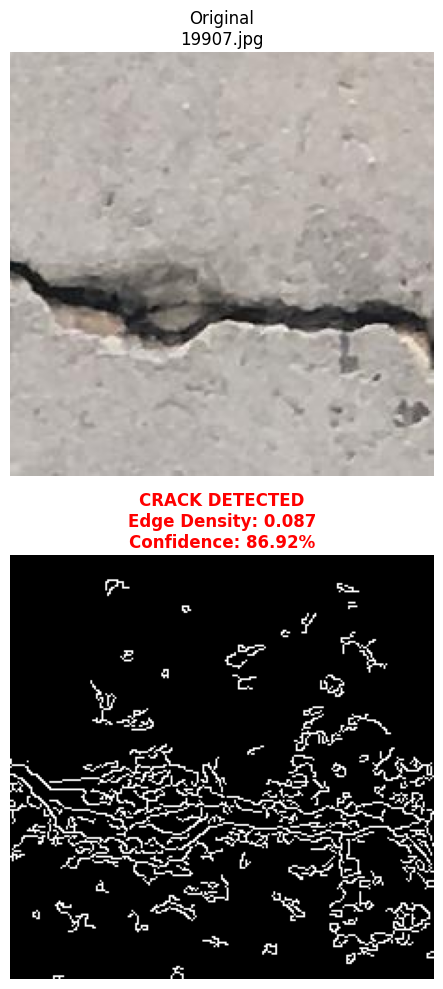


✅ Detection complete!


In [16]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

class CrackDetector:
    def __init__(self, model_path=None):
        """
        Initialize the crack detector with a trained model
        """
        if model_path and os.path.exists(model_path):
            self.model = load_model(model_path)
            print("✅ Pre-trained model loaded successfully!")
        else:
            print("⚠️  No model found. Please train the model first.")
            self.model = None
    
    def preprocess_image(self, image_path, img_size=(224, 224)):
        """
        Preprocess the image for crack detection
        """
        try:
            # Read and resize image
            img = cv2.imread(image_path)
            if img is None:
                raise ValueError(f"Could not load image from {image_path}")
            
            original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(original_img, img_size)
            
            # Apply crack enhancement (same as training)
            gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            enhanced = clahe.apply(gray)
            edges = cv2.Canny(enhanced, 50, 150)
            edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
            
            # Blend with original
            alpha = 0.7
            processed_img = cv2.addWeighted(img_resized, 1-alpha, edges_rgb, alpha, 0)
            
            # Normalize for model input
            processed_img = processed_img.astype('float32') / 255.0
            processed_img = np.expand_dims(processed_img, axis=0)
            
            return processed_img, original_img, img_resized
            
        except Exception as e:
            print(f"❌ Error preprocessing image {image_path}: {e}")
            return None, None, None
    
    def predict_crack(self, image_path, confidence_threshold=0.5):
        """
        Predict if an image contains cracks
        """
        if self.model is None:
            print("❌ No model available for prediction")
            return None, None, None
        
        # Preprocess image
        processed_img, original_img, resized_img = self.preprocess_image(image_path)
        
        if processed_img is None:
            return None, None, None
        
        # Make prediction
        prediction = self.model.predict(processed_img, verbose=0)
        confidence = prediction[0][0]
        
        # Determine class
        if confidence > confidence_threshold:
            label = "CRACK"
            color = "red"
        else:
            label = "NO CRACK"
            color = "green"
            confidence = 1 - confidence  # Show confidence for the predicted class
        
        return label, confidence, original_img, resized_img
    
    def detect_multiple_images(self, image_paths, confidence_threshold=0.5):
        """
        Detect cracks in multiple images and display results
        """
        if not image_paths:
            print("❌ No image paths provided")
            return
        
        num_images = len(image_paths)
        
        # Create subplot
        fig, axes = plt.subplots(2, num_images, figsize=(6*num_images, 10))
        if num_images == 1:
            axes = axes.reshape(2, 1)
        
        results = []
        
        for i, image_path in enumerate(image_paths):
            print(f"\n🔍 Analyzing: {image_path}")
            
            if not os.path.exists(image_path):
                print(f"❌ Image not found: {image_path}")
                continue
            
            # Get prediction
            label, confidence, original_img, processed_img = self.predict_crack(
                image_path, confidence_threshold
            )
            
            if original_img is None:
                continue
            
            # Store results
            results.append({
                'path': image_path,
                'label': label,
                'confidence': confidence,
                'original': original_img,
                'processed': processed_img
            })
            
            # Display original image
            axes[0, i].imshow(original_img)
            axes[0, i].set_title(
                f'Original\n{os.path.basename(image_path)}\nSize: {original_img.shape[1]}x{original_img.shape[0]}', 
                fontsize=12
            )
            axes[0, i].axis('off')
            
            # Display processed image with prediction
            axes[1, i].imshow(processed_img)
            
            # Set color based on prediction
            title_color = 'red' if label == "CRACK" else 'green'
            
            axes[1, i].set_title(
                f'Prediction: {label}\nConfidence: {confidence:.2%}', 
                fontsize=14, 
                color=title_color,
                fontweight='bold'
            )
            axes[1, i].axis('off')
            
            # Print results
            print(f"   🎯 Prediction: {label}")
            print(f"   📊 Confidence: {confidence:.2%}")
            print(f"   📏 Image size: {original_img.shape[1]}x{original_img.shape[0]}")
        
        plt.tight_layout()
        plt.show()
        
        return results

# Alternative function if you don't have a trained model yet
def quick_crack_detection(image_paths):
    """
    Quick crack detection using image processing (no ML model required)
    """
    print("🔍 QUICK CRACK DETECTION USING IMAGE PROCESSING")
    print("=" * 50)
    
    num_images = len(image_paths)
    fig, axes = plt.subplots(2, num_images, figsize=(6*num_images, 10))
    if num_images == 1:
        axes = axes.reshape(2, 1)
    
    for i, image_path in enumerate(image_paths):
        print(f"\nAnalyzing: {image_path}")
        
        if not os.path.exists(image_path):
            print(f"❌ Image not found: {image_path}")
            continue
        
        try:
            # Load and preprocess image
            img = cv2.imread(image_path)
            original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Convert to grayscale
            gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
            
            # Apply edge detection
            edges = cv2.Canny(gray, 50, 150)
            
            # Calculate edge density
            total_pixels = edges.shape[0] * edges.shape[1]
            edge_pixels = np.sum(edges > 0)
            edge_density = edge_pixels / total_pixels
            
            # Simple rule-based classification
            if edge_density > 0.02:  # Threshold for crack detection
                label = "CRACK DETECTED"
                color = "red"
                confidence = min(edge_density * 10, 0.95)  # Scale to confidence
            else:
                label = "NO CRACK"
                color = "green"
                confidence = 1.0 - min(edge_density * 10, 0.95)
            
            # Display original image
            axes[0, i].imshow(original)
            axes[0, i].set_title(f'Original\n{os.path.basename(image_path)}', fontsize=12)
            axes[0, i].axis('off')
            
            # Display edges
            axes[1, i].imshow(edges, cmap='gray')
            axes[1, i].set_title(
                f'{label}\nEdge Density: {edge_density:.3f}\nConfidence: {confidence:.2%}', 
                fontsize=12, 
                color=color,
                fontweight='bold'
            )
            axes[1, i].axis('off')
            
            print(f"   🎯 Result: {label}")
            print(f"   📊 Edge Density: {edge_density:.3f}")
            print(f"   📈 Confidence: {confidence:.2%}")
            
        except Exception as e:
            print(f"❌ Error processing {image_path}: {e}")
    
    plt.tight_layout()
    plt.show()

# MAIN EXECUTION
if __name__ == "__main__":
    import os
    
    print("🔄 CRACK DETECTION SYSTEM")
    print("=" * 50)
    
    # METHOD 1: Using trained model (if available)
    model_path = "crack_detection_enhanced_model.h5"  # Change this if your model has different name
    
    if os.path.exists(model_path):
        print("🚀 Using trained model for prediction...")
        detector = CrackDetector(model_path)
        
        # Provide your image paths here
        image_paths = [
            "C:/Users/sanap/Downloads/Dataset 2/Positive/19907.jpg"  # Replace with your second image path
        ]
        
        # Remove non-existent paths
        valid_paths = [path for path in image_paths if os.path.exists(path)]
        
        if valid_paths:
            results = detector.detect_multiple_images(valid_paths)
        else:
            print("❌ No valid image paths found. Using quick detection instead.")
            # METHOD 2: Quick detection (no model required)
            quick_crack_detection([
                r"C:/Users/sanap/Downloads/Non Crack image.jpg",
                r"C:/Users/sanap/Downloads/Crack image.jpg"
            ])
    
    else:
        print("⚠️  No trained model found. Using image processing method...")
        # METHOD 2: Quick detection using image processing
        quick_crack_detection([
            r"C:/Users/sanap/Downloads/Dataset 2/Positive/19907.jpg"   # REPLACE with your second image path
        ])
    
    print("\n" + "=" * 50)
    print("✅ Detection complete!") 